In [1]:
import sys

import gc
import itertools
import math
import os
import random
import re
from datetime import datetime
from importlib import reload

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import psutil
import pydotplus
import seaborn as sns
import shap

from IPython.display import Image
from lightgbm import LGBMClassifier
from scipy.stats import norm
from seaborn import heatmap
from sklearn import metrics, tree
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from tqdm.notebook import tqdm


from pipeline_utils import (append_for_deletion, 
                            remove_from_deletion, 
                            funnel_func, 
                            mu,
                            roc_lift_gain, 
                            time_ranges_plot,
                            binary_hists, 
                            bootscores_concat,
                            by_month, 
                            check_nans, 
                            count_data, 
                            display_nicely,
                            drop_unnamed, 
                            get_pretty_dates, 
                            model_stats,
                            show_descriptions,
                            show_sources)

from ml_pipeline import (attributes_list_new, 
                         bootstrap,
                         br_correction, 
                         by_month_gini,
                         calculate_vif,
                         check_attribute_list_cases,
                         data_preprocessing,
                         data_preprocessing_test,
                         data_preprocessing_train,
                         feature_importance,
                         find_doubles_corr, 
                         find_meta_params,
                         find_meta_params_optuna,
                         find_ouliers_iqr, 
                         for_splines,
                         get_stats, 
                         get_stats_by_month,
                         get_stats_on_target,
                         get_stats_on_target_by_month, 
                         linear_calib_use_model_data,
                         lr_test_all_features, 
                         make_standard,
                         plot_meta_2d, 
                         receive_correlations,
                         simple_b_score_crm, 
                         stable_unstable,
                         stable_unstable_by_month_divide,
                         statistics_with_target,
                         stratified_split,
                         train_model_receive_stats,
                         turn_variables_with_values,
                         two_forests, 
                         union_datas)

ml_pipeline.py version: Created: 03.06.2022 01:09, Modified: 03.06.2022 01:08.


# **Input data**

In [17]:
PATH_ROOT = 'D:/Share/asmirnova5/Branch_2019/' #путь основной папки 
PATH = PATH_ROOT  #путь папки с моделью
print(PATH)

D:/Share/asmirnova5/Branch_2019/


In [3]:

description_file = 'C:/Work/01 -Risk Desc Science/CRM/Branch_2019/Переменные_trigger_Branch.xlsx' 
field_for_var_in_desc = 'Переменная' 
field_for_comment_in_desc = 'Описание' 
field_for_type_in_desc = 'Тип' 


categorial_file = 'C:/Work/01 -Risk Desc Science/CRM/Branch_2019/Переменные_trigger_Branch_категориальные.xlsx'
field_for_var_in_cats = 'Переменная' 

In [4]:
datasets_file = 'data_Branch.zip' 
train_data = 'Branch_train_for_model.zip' 
test_data = 'Branch_test_for_model.zip' 
oot_data = 'Branch_oot_for_model.zip' 

black_list = 'Переменные_trigger_Branch_black_list.xlsx' 
black_field_var = 'Переменная' 
filename_dump = 'Branch.data' 

task = 'binary' 
missing_strings = 'MISSING' 
p_value = 0.05 

recommended_list = False 
target_dict = {'good': 1, 'bad': 0} 

In [5]:
target = 'good_flag' 
index_month = 'month_call'
list_of_vars_for_strat = ['month_call']
sort_by_var = 'cif_id'

necessary_fields = [target, index_month, sort_by_var]
necessary_fields_upper = [target.upper(), index_month.upper(), sort_by_var.upper()] 


COL_SYS = ['INITIATED_DT', 'ROBOT_DAY', 'DEL_FLAG', 'INITIATED_DT_OUT',
'CALL_OUT_DAY', 'SD', 'SMS_DAY', 'MONTHCALLMINUS2',
'XSBASEDT_24M', 'XSBASEDT_12M', 'CALLDT', 'CALCDT_1M',
'CALCDT_3M', 'CALCDT_6M', 'CALCDT_12M', 'CALCDT_24M',
'CLIENT_NUMBER_TEXT', 'CIF_ID_TEXT', 'CLIENT_NUMBER',
'DATE_REPORT_O', 'DATE_REPORT_B', 'SUPERID', 'SUPERID_OPEN',
'SUPERID_AP', 'SUPERID_BUREAU', 'BUREAU_DT', 'UNNAMED: 0', index_month.upper()+'_GROSS', 'ACTIVE_IND']
COL_TRG = target.upper()
hyper_disbalance= False

In [9]:
list_of_vars_for_strat_upper = [c.upper() for c in list_of_vars_for_strat]
sort_by_var_upper = sort_by_var.upper()

In [11]:
def column_dic(x, dic):
    return dic.get(x.upper(),
                        dic.get(re.sub(r'[0-9]+', 'NN', x).upper(),
                                     dic.get(re.sub(r'[0-9]+_2', 'NN_2', x).upper(),
                                                 dic.get(re.sub(r'2ALL_[0-9]+', '2All_NN', x).upper())
                                                 )
                                    )
                       )

## List of variables

In [12]:
print_log('Создание вспомогательных справочников')

sheet_names = ['Лист1']
Var_type = {}
Var_desc = {}
for sheet_name in sheet_names:
#C:\Work\01 -Risk Desc Science\Application\GP\Repeat\Selection\excel    
    Var_dic = pd.read_excel(description_file,sheet_name=sheet_name)
    Var_dic[field_for_var_in_desc]= Var_dic[field_for_var_in_desc].apply(lambda x: x.upper())
    print('На листе ' + sheet_name)
    print(Var_dic[field_for_type_in_desc].value_counts())
    #Словарь типов фичей
    Var_type.update(Var_dic[[field_for_var_in_desc,
                     field_for_type_in_desc]].set_index(field_for_var_in_desc).to_dict()[field_for_type_in_desc])
    #Словать описаний фичей
    Var_desc.update(Var_dic[[field_for_var_in_desc,
                     field_for_comment_in_desc]].set_index(field_for_var_in_desc).to_dict()[field_for_comment_in_desc])
print('\n В словаре переменных ', len(Var_desc))


Создание вспомогательных справочников
На листе Лист1
Непрерывная       1198
Категориальная     136
Дата                27
Name: Тип, dtype: int64

 В словаре переменных  1361


In [14]:
if recommended_list == True:
    col_from_list = pd.read_csv(PATH+'Data Sets/'+recommend_list, header = 0 , delimiter = '&')
    col_from_list = [c.upper() for c in col_from_list.feature]

In [15]:


if recommended_list == True:
    col_nn = {} 
    for c in [c.upper() for c in data.columns]:
        for r in col_from_list:
            dcol = c
            if dcol == r:
                col_nn[c] = r
                break
            dcol = re.sub(r'[0-9]+', 'NN', c)
            if dcol == r:
                col_nn[c] = r
                break
            dcol = re.sub(r'[0-9]+_2', 'NN_2', c)
            if dcol == r:
                col_nn[c] = r
                break
            dcol = re.sub(r'2ALL_[0-9]+', '2ALL_NN', c)
            if dcol == r:
                col_nn[c] = r
                break
            dcol = re.sub('7D', 'NNM', c)
            if dcol == r:
                col_nn[c] = r
                break
            dcol = re.sub(r'ALL[0-9]+', 'ALLNN', c)
            if dcol == r:
                col_nn[c] = r
                break
            dcol = re.sub(r'ALLL[0-9]+', 'ALLLNN', c)
            if dcol == r:
                col_nn[c] = r
                break
            dcol = re.sub(r'[0-9]+M', 'NNM', c)
            if dcol == r:
                col_nn[c] = r
                break

    COL_DEL = []

    COL_DEL = [c.upper() for c in data.columns if c.upper() not in list(col_nn.keys()) + COL_SYS + [COL_TRG]]
    len(COL_DEL)

    for c in COL_DEL:
        print(c, column_dic(c,Var_desc))
else:
    COL_DEL = []

#  **Variable selection**

## Data import 

In [19]:

data = pd.read_csv(PATH_ROOT + 'Data Sets/' + train_data, header = 0 , delimiter = '&', encoding = 'cp1251')

C:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning:

Columns (1195) have mixed types.Specify dtype option on import or set low_memory=False.



In [23]:
train = pd.read_csv( PATH + 'Data Sets/' + train_data,
                   delimiter='&',
                   index_col=0,
                   encoding='cp1251'
                  )

In [24]:
test = pd.read_csv( PATH + 'Data Sets/' + test_data,
                   delimiter='&',
                   index_col=0,
                   encoding='cp1251'
                  )

In [25]:
oot = pd.read_csv( PATH + 'Data Sets/' + oot_data,
                   delimiter='&',
                   index_col=0,
                   encoding='cp1251'
                  )

In [ ]:
data.head()

In [ ]:
gc.collect()

### Data check

In [20]:
bad_rate_by_month = data.groupby(index_month).aggregate({index_month: 'count',
                                     target: ['count', 'mean']})
bad_rate_by_month.reset_index(inplace = True)
bad_rate_by_month.columns = [' '.join(col).strip() for col in bad_rate_by_month.columns.values]
bad_rate_by_month[target+' mean-1'] = 1-bad_rate_by_month[target+' mean']
if target_dict['bad'] == 1:
    bad_rate_by_month.rename(columns = {index_month+' count': 'all_count', target+' count': 'filling of target', 
                                       target+' mean': 'bad_rate', target+' mean-1':'good_rate'}, inplace = True)
else:
    bad_rate_by_month.rename(columns = {index_month+' count': 'all_count', target+' count': 'filling of target', 
                                       target+' mean': 'good_rate', target+' mean-1':'bad_rate'}, inplace = True)
bad_rate_by_month

month_call  all_count  filling of target  good_rate  bad_rate
0      201911     106799             106799   0.015178  0.984822
1      201912     145335             145335   0.012805  0.987195
2      202001     126780             126780   0.012423  0.987577
3      202002     167049             167049   0.011134  0.988866

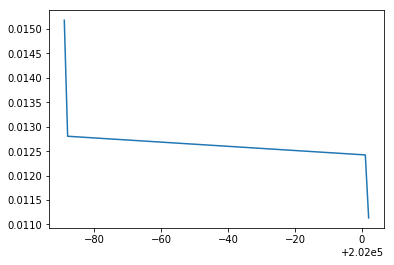

In [21]:
plt.plot(bad_rate_by_month[index_month], bad_rate_by_month['good_rate'])

In [22]:
bad_rate_by_month.to_csv(PATH+'bad_rate_dynamic.csv')

### Train/Test/Oot

In [23]:
print('Start Бьем выборку на выборку для Train/Test и OOT')
oot = data[data[index_month]>=202001]
tt  = data[data[index_month]<202001]#TRAIN_TEST

Start Бьем выборку на выборку для Train/Test и OOT


In [24]:
print(tt.shape, oot.shape, data.shape)

(378914, 1225) (167049, 1225) (545963, 1225)


In [25]:
X_1, X_2, y_1, y_2 = stratified_split(tt, target, list_of_vars_for_strat, sort_by_var, size_of_test = 0.2, 
                                      drop_technical = False,
                                      random_state = 241)
X_1 = X_1.join(y_1)
X_2 = X_2.join(y_2)

In [26]:
print_log('Write train')
X_1.to_csv(PATH + 'Data Sets/' +  train_data, sep = '&', encoding = 'cp1251')
print_log('Write test')
X_2.to_csv(PATH + 'Data Sets/' +  test_data , sep = '&', encoding = 'cp1251')
print_log('Write oot')
oot.to_csv( PATH + 'Data Sets/' +  oot_data  , sep = '&', encoding = 'cp1251')

print_log('Write END')

Write train
Write test
Write oot
Write END


In [16]:
gc.collect()

1546

In [28]:
del(X_1, X_2)
del(tt, oot, data)

### Train upload

In [17]:
data = pd.read_csv(PATH + 'Data Sets/' +  train_data, sep = '&', encoding = 'cp1251')
data.columns = [col.upper() for col in data.columns]

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (1195) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [20]:
#COL_SYS.append(target1)

target = 'GOOD_FLAG'

In [21]:
target

'GOOD_FLAG'

In [22]:
COL_SYS = [i.upper() for i in COL_SYS]

In [23]:
# Готовим справочник типов переменных, с которыми будем загружать весь объем данных
type_cols = {}
COL_CAT = []
COL_NUM = []
COL_OBJ = []
for c in [c for c in data.columns if c.upper() not in COL_DEL]:
    if data[c].dtype == 'object': 
        # Здесь соберем переменные типа 'object'
        type_cols[c] = 'object'
        COL_OBJ.append(c.upper())
    elif column_dic(c.upper(), Var_type) == 'Непрерывная':
        # Здесь соберем переменные типа 'float'
        type_cols[c] = np.float32
        COL_NUM.append(c.upper())
    else:                        
        # Здесь соберем категориальные переменные типа 'int'
        # сюда же попадут те переменные, которые не описаны в справочнике Var_type ()
        type_cols[c] = 'Int64'
        COL_CAT.append(c.upper())
print('тип объект         = ', len(COL_OBJ))
print('тип категориальные = ', len(COL_CAT))
print('тип непрерывные    = ', len(COL_NUM))
#type_cols

тип объект         =  8
тип категориальные =  118
тип непрерывные    =  1100


In [24]:
deleted = pd.DataFrame({'feature': [], 'reason': []})

### Black list

In [25]:
col_for_del_black = pd.read_excel(PATH + black_list, header = 0, encoding = 'cp1251')
col_for_del_black = col_for_del_black[black_field_var].to_list()
col_for_del_black_list = [col.upper() for col in col_for_del_black if col.upper() not in necessary_fields_upper]

In [26]:
col_black_list = [] # Справочник рекомендованных/черных переменных с их сокращенными вариантами
for c in [c.upper() for c in data.columns]:
    for r in col_for_del_black_list:
        dcol = c
        if dcol == r:
            col_black_list.append(['black_list', c])
            break
        dcol = re.sub(r'[0-9]+', 'NN', c)
        if dcol == r:
            col_black_list.append(['black_list', c])
            break
        dcol = re.sub(r'[0-9]+_2', 'NN_2', c)
        if dcol == r:
            col_black_list.append(['black_list', c])
            break
        dcol = re.sub(r'2ALL_[0-9]+', '2ALL_NN', c)
        if dcol == r:
            col_black_list.append(['black_list', c])
            break
        dcol = re.sub('7D', 'NNM', c)
        if dcol == r:
            col_black_list.append(['black_list', c])
            break
        dcol = re.sub(r'ALL[0-9]+', 'ALLNN', c)
        if dcol == r:
            col_black_list.append(['black_list', c])
            break
        dcol = re.sub(r'ALLL[0-9]+', 'ALLLNN', c)
        if dcol == r:
            col_black_list.append(['black_list', c])
            break
        dcol = re.sub(r'[0-9]+M', 'NNM', c)
        if dcol == r:
            col_black_list.append(['black_list', c])
            break
            
column_names = ['reason', 'feature']

col_black_list = pd.DataFrame.from_records(col_black_list, columns = column_names)

In [27]:
deleted = deleted.append(col_black_list, ignore_index = True, sort = False)

In [28]:
deleted

feature      reason
0   HITEQUIFAX_AD  black_list
1        HITRS_AD  black_list
2      HITNBKI_AD  black_list
3  HITEXPERIAN_AD  black_list

In [29]:
col_black_list = col_black_list['feature'].to_list()
col_black_list = [col.upper() for col in col_black_list if col.upper() not in necessary_fields_upper]
columns = data.columns
columns = [i for i in columns if i not in col_black_list]

In [30]:
for i in data.columns:
    if i in col_black_list and i not in COL_DEL and i not in necessary_fields_upper:
        COL_DEL.append(i)

COL_DEL.append('EMPINDUSTRY_AP')
COL_DEL.append('EMPTITLEENUM_AP')
        
region_del = []
for i in list(data.columns):
    if len(re.findall('REGION', i)) > 0 or len(re.findall('CITY', i)) > 0 or len(re.findall('DATE', i)) > 0:
        print(i)
        region_del.append(i)
        
for i in region_del:
    if i not in COL_DEL:
        COL_DEL.append(i)
        
for i in COL_SYS:
    COL_DEL.append(i)
    
len(COL_DEL)

CITY_BRANCH
CNCT_CLOSED_DATE
REGION_HOME


38

In [31]:
gc.collect()

335

In [32]:
#Сохранить отдельную сборку для удаленных переменных
file_name = PATH + 'Selection/excel/1. BL_Сборка_Сэмпла.xlsx'
deleted[deleted.feature.isin(COL_DEL)].to_excel(file_name, index = False)

## Data quality analysis

In [33]:
# сколько каких переменных осталось?
COL_NUM = [c for c in COL_NUM if c not in COL_DEL]
COL_CAT = [c for c in COL_CAT if c not in COL_DEL]
COL_OBJ = [c for c in COL_OBJ if c not in COL_DEL]
print('тип объект         = ', len(COL_OBJ))
print('тип категориальные = ', len(COL_CAT))
print('тип непрерывные    = ', len(COL_NUM))

тип объект         =  6
тип категориальные =  110
тип непрерывные    =  1100


In [34]:
print_log('Run attribute_list')
attribute_list = attributes_list_new(data, columns, [0.01, 0.5, 1, 2, 5, 95, 98, 99, 99.5, 99.99])
print_log('End attribute_list')

Run attribute_list
[1.000e-04 5.000e-03 1.000e-02 2.000e-02 5.000e-02 9.500e-01 9.800e-01
 9.900e-01 9.950e-01 9.999e-01]
Number of finished repetitions: 0 | time:  10.03.2020 18:17:02
Number of finished repetitions: 100 | time:  10.03.2020 18:17:48
Number of finished repetitions: 200 | time:  10.03.2020 18:18:21
Number of finished repetitions: 300 | time:  10.03.2020 18:18:55
Number of finished repetitions: 400 | time:  10.03.2020 18:19:35
Number of finished repetitions: 500 | time:  10.03.2020 18:20:13
Number of finished repetitions: 600 | time:  10.03.2020 18:21:04
Number of finished repetitions: 700 | time:  10.03.2020 18:21:36
Number of finished repetitions: 800 | time:  10.03.2020 18:22:11
Number of finished repetitions: 900 | time:  10.03.2020 18:22:52
Number of finished repetitions: 1000 | time:  10.03.2020 18:23:24
Number of finished repetitions: 1100 | time:  10.03.2020 18:24:07
Number of finished repetitions: 1200 | time:  10.03.2020 18:24:37
End attribute_list


In [35]:
len(columns), attribute_list.shape

(1222, (1222, 25))

In [36]:
attribute_list.to_csv(PATH + 'Selection/SandBox/attribute_list_var.csv', sep='&')

In [37]:
description = pd.read_excel(description_file, encoding = 'cp1251')
description[field_for_var_in_desc] = [var.upper() for var in description[field_for_var_in_desc]]
description.rename(columns = {field_for_var_in_desc: 'attribute', field_for_comment_in_desc: 'description',
                             field_for_type_in_desc: 'type_desc'}, inplace = True)

In [38]:
attribute_list = pd.merge(attribute_list, description[['attribute', 'description', 'type_desc']], on = 'attribute', 
                          how = 'left')

In [39]:
for c in attribute_list.loc[attribute_list['description'].isna() == True, 'attribute']:
    for r in description['attribute']:
        dcol = c
        if dcol == r:
            attribute_list.loc[attribute_list['attribute'] == 
                               c, 'description'] = description.loc[description['attribute'] == 
                                                                                    r, 'description'].to_list()[0]
            break
        dcol = re.sub(r'[0-9]+', 'NN', c)
        if dcol == r:
            attribute_list.loc[attribute_list['attribute'] == 
                               c, 'description'] = description.loc[description['attribute'] == 
                                                                                    r, 'description'].to_list()[0]
            break
        dcol = re.sub(r'[0-9]+_2', 'NN_2', c)
        if dcol == r:
            attribute_list.loc[attribute_list['attribute'] == 
                               c, 'description'] = description.loc[description['attribute'] == 
                                                                                    r, 'description'].to_list()[0]
            break
        dcol = re.sub(r'2ALL_[0-9]+', '2ALL_NN', c)
        if dcol == r:
            attribute_list.loc[attribute_list['attribute'] == 
                               c, 'description'] = description.loc[description['attribute'] == 
                                                                                    r, 'description'].to_list()[0]
            break
        dcol = re.sub('7D', 'NNM', c)
        if dcol == r:
            attribute_list.loc[attribute_list['attribute'] == 
                               c, 'description'] = description.loc[description['attribute'] == 
                                                                                    r, 'description'].to_list()[0]
            break
        dcol = re.sub(r'ALL[0-9]+', 'ALLNN', c)
        if dcol == r:
            attribute_list.loc[attribute_list['attribute'] == 
                               c, 'description'] = description.loc[description['attribute'] == 
                                                                                    r, 'description'].to_list()[0]
            break
        dcol = re.sub(r'ALLL[0-9]+', 'ALLLNN', c)
        if dcol == r:
            attribute_list.loc[attribute_list['attribute'] == 
                               c, 'description'] = description.loc[description['attribute'] == 
                                                                                    r, 'description'].to_list()[0]
            break
        dcol = re.sub(r'[0-9]+M', 'NNM', c)
        if dcol == r:
            attribute_list.loc[attribute_list['attribute'] == 
                               c, 'description'] = description.loc[description['attribute'] == 
                                                                                    r, 'description'].to_list()[0]
            break

In [41]:
data.shape, attribute_list.shape

((303220, 1226), (1222, 27))

In [42]:
for i in data.columns:
    if i not in attribute_list['attribute'].to_list():
        print(i)

HITEQUIFAX_AD
HITRS_AD
HITNBKI_AD
HITEXPERIAN_AD


In [43]:
# no filled values
attribute_list_all_misses = attribute_list[(attribute_list['count_miss'] == data.shape[0])]

# too many bin's, suspect ID
attribute_list_object_many_distinct =  attribute_list[(attribute_list['count_dist'] >= 150)
                                        & (attribute_list['type_val']!= 'float32')
                                        & (attribute_list['type_val']!= 'float64')] # == 'int')]

# over 97% missed
attribute_list_many_misses = attribute_list[(attribute_list['count_miss'] >= data.shape[0]*0.97)
                                            & (attribute_list['count_miss'] != data.shape[0])]

# too many unique values, suspect ID
attribute_list_all_distinct = attribute_list[(attribute_list['count_dist'] >= data.shape[0]*0.95)] 

# variable has only one value:
attribute_list_сonst =  attribute_list[(attribute_list['count_dist'] == 1) & (attribute_list['count_miss'] == 0)]

# variable has only one value, missing is allowed
attribute_list_one_value = attribute_list[(attribute_list['count_dist'] == 1) & (attribute_list['count_miss'] != 0)]

# 1%-percentile equals 99%-percentile
attribute_list_1_eq_99 =attribute_list[(attribute_list['1%'] == attribute_list['99%'])]

In [44]:
attribute_list_all_misses

attribute type_val  count_dist  count_miss  moda_val  \
484  BANKRUPT_SUM_C  float64           0      303220       NaN   

     count_value_moda count_val unique  top freq  ...   5% val_mediana  95%  \
484               NaN         0    NaN  NaN  NaN  ...  NaN         NaN  NaN   

     98%  99% 99.5% 99.99% max_val  \
484  NaN  NaN   NaN    NaN     NaN   

                                           description    type_desc  
484  суммарный лимит по контрактам клиента в статус...  Непрерывная  

[1 rows x 27 columns]

In [45]:
attribute_list_object_many_distinct

attribute type_val  count_dist  count_miss      moda_val  \
0                  UNNAMED: 0    int64      303220           0  0.000000e+00   
1                      CIF_ID    int64      252086           0  1.039381e+09   
922   C_DAYSINDELINQUENCYL12M    int64         209           0  0.000000e+00   
1157         CNCT_CLOSED_DATE   object        1311       53008 -1.000000e+03   

      count_value_moda count_val unique                 top   freq  ...  \
0                  1.0    303220    NaN                 NaN    NaN  ...   
1                  9.0    303220    NaN                 NaN    NaN  ...   
922           231074.0    303220    NaN                 NaN    NaN  ...   
1157           -1000.0    250212   1311  31DEC9999:00:00:00  99236  ...   

               5%  val_mediana          95%          98%          99%  \
0           18949       189596       359997       371371       375148   
1     1.00217e+09  1.02556e+09  1.03988e+09  1.04041e+09  1.04062e+09   
922             0            0           13           29           45   
1157          NaN          NaN          NaN          NaN          NaN   

            99.5%       99.99%    max_val  \
0          377000       378877     378913   
1     1.04085e+09  1.04113e+09  2.147e+09   
922            64      193.678        365   
1157          NaN          NaN        NaN   

                                            description    type_desc  
0                                                   NaN          NaN  
1                                            ID клиента  Непрерывная  
922   Количество дней в Collection 0+ за последние N...  Непрерывная  
1157                                                NaN          NaN  

[4 rows x 27 columns]

In [46]:
attribute_list_all_distinct

attribute type_val  count_dist  count_miss  moda_val  count_value_moda  \
0  UNNAMED: 0    int64      303220           0       0.0               1.0   

  count_val unique  top freq  ...     5% val_mediana     95%     98%     99%  \
0    303220    NaN  NaN  NaN  ...  18949      189596  359997  371371  375148   

    99.5%  99.99% max_val description type_desc  
0  377000  378877  378913         NaN       NaN  

[1 rows x 27 columns]

In [47]:
attribute_list_many_misses

attribute type_val  count_dist  count_miss  \
78                  CASHCMTOCASHL1M_O  float64         645      300855   
79                 CASHL3MTOCASHL6M_O  float64        2128      295592   
123              MONTHSSINCELAST60P_B  float64         170      297152   
124              MONTHSSINCELAST90P_B  float64         167      298614   
127               SUMOVERDUE60PEVER_B  float64        4379      297152   
128               SUMOVERDUE90PEVER_B  float64        3257      298614   
132                   COUNTINACTIVE_B  float64           3      297197   
158               MAXOVERDUE60PEVER_B  float64        4428      297152   
159               MAXOVERDUE90PEVER_B  float64        3297      298614   
161               MAXOVERDUE30PL24M_B  float64        1433      301466   
162               MAXOVERDUE60PL24M_B  float64         487      302607   
163               MAXOVERDUE90PL24M_B  float64         260      302885   
165               MAXOVERDUE30PL12M_B  float64        1019      301982   
166               MAXOVERDUE60PL12M_B  float64         399      302714   
167               MAXOVERDUE90PL12M_B  float64         222      302929   
169                MAXOVERDUE30PL6M_B  float64         685      302390   
170                MAXOVERDUE60PL6M_B  float64         315      302821   
171                MAXOVERDUE90PL6M_B  float64         196      302964   
172                MAXOVERDUE00PL3M_B  float64        7122      294869   
173                MAXOVERDUE30PL3M_B  float64         490      302613   
174                MAXOVERDUE60PL3M_B  float64         251      302901   
177               AVGOVERDUE60PEVER_B  float64        4461      297152   
179               AVGOVERDUE30PL24M_B  float64        1429      301466   
180               AVGOVERDUE60PL24M_B  float64         182      303010   
181               AVGOVERDUE90PL24M_B  float64         260      302885   
183               AVGOVERDUE30PL12M_B  float64        1017      301982   
184               AVGOVERDUE60PL12M_B  float64         176      303010   
185               AVGOVERDUE90PL12M_B  float64         223      302929   
187                AVGOVERDUE30PL6M_B  float64         686      302390   
188                AVGOVERDUE60PL6M_B  float64         315      302821   
...                               ...      ...         ...         ...   
849             VERYPOSTOALLWITHCN_12  float64         125      298559   
1024     C_DAYSSINCELASTINBOUNDALLL1M  float64          32      300171   
1028  C_DAYSSINCELASTINBOUNDALLL1M_CL  float64          32      300294   
1029  C_DAYSSINCELASTINBOUNDALLL3M_CL  float64          93      294262   
1036   C_DAYSSINCELASTOUTBOUNDL1M_ANY  float64          32      299244   
1086            C_CURPTPAMTALLL12M2BO  float64        1615      300435   
1087             C_CURPTPAMTALLL6M2BO  float64        1402      300435   
1088             C_CURPTPAMTALLL3M2BO  float64        1148      300435   
1089             C_CURPTPAMTALLL1M2BO  float64         791      300435   
1093          C_MAXDAYSTOANYCONTACT1M  float64          36      299481   
1094          C_MINDAYSTOANYCONTACT1M  float64          33      299481   
1095          C_MAXDAYSTOANYCONTACT3M  float64          49      294336   
1096          C_MINDAYSTOANYCONTACT3M  float64          42      294336   
1104             C_PTP2OUTBOUNDALLL1M  float64          21      299244   
1105             C_PTP2OUTBOUNDALLL7D  float64           6      301970   
1109         C_PTP2OUTBOUNDALLL1M_NSD  float64          19      299339   
1110         C_PTP2OUTBOUNDALLL7D_NSD  float64           6      302101   
1111         C_COUNTIN2COUNTOUTALLL1M  float64          18      299244   
1122        C_UNSUCESSFUL2OUTBOUNDL1M  float64          24      299244   
1125     C_RPCALL2ANYPERSONCONTACTL3M  float64          64      294290   
1126     C_RPCALL2ANYPERSONCONTACTL1M  float64          23      299468   
1129     C_PTPALL2ANYPERSONCONTACTL3M  float64          52      294290   
1130     C_PTPALL2ANYPERSONCONTA

In [48]:
def features_for_delete(attribute_list_reason, reason): 
    for_del = pd.DataFrame({'feature': attribute_list_reason['attribute'].to_list()})
    for_del.insert(1, 'reason', reason)
    return for_del

In [49]:
deleted = pd.DataFrame({'feature': [], 'reason': []})

In [50]:
attribute_list_all_misses[['attribute', 'description']]

attribute                                        description
484  BANKRUPT_SUM_C  суммарный лимит по контрактам клиента в статус...

In [51]:
deleted = deleted.append(features_for_delete(attribute_list_all_misses,'all_misses'), ignore_index = True)

In [52]:
attribute_list_сonst[['attribute', 'description']]

attribute  \
1196        CLIENT_FLAG_AGENCY_AKTZEPT   
1197           CLIENT_FLAG_AGENCY_BANK   
1198  CLIENT_FLAG_AGENCY_BRANDINTERCOU   
1199            CLIENT_FLAG_AGENCY_CDU   
1201        CLIENT_FLAG_AGENCY_FILBERT   
1202         CLIENT_FLAG_AGENCY_KONSUL   
1203      CLIENT_FLAG_AGENCY_LITIGATOR   
1206            CLIENT_FLAG_AGENCY_PDD   
1207        CLIENT_FLAG_AGENCY_PARITET   
1208  CLIENT_FLAG_AGENCY_RUSDOLGNADZOR   
1209       CLIENT_FLAG_AGENCY_SENTINEL   
1210            CLIENT_FLAG_AGENCY_USB   
1211             FLAG_CLIENT_AGENCY_3M   

                                     description  
1196               Флаг "Был в агенстве Aktzept"  
1197                  Флаг "Был в агенстве Bank"  
1198         Флаг "Был в агенстве BrandIntercou"  
1199                   Флаг "Был в агенстве CDU"  
1201               Флаг "Был в агенстве Filbert"  
1202                Флаг "Был в агенстве Konsul"  
1203             Флаг "Был в агенстве Litigator"  
1206                   Флаг "Был в агенстве PDD"  
1207               Флаг "Был в агенстве Paritet"  
1208         Флаг "Был в агенстве RusDolgNadzor"  
1209              Флаг "Был в агенстве Sentinel"  
1210                   Флаг "Был в агенстве USB"  
1211  Флаг "Был в агентстве в течение 3 месяцев"

In [53]:
deleted = deleted.append(features_for_delete(attribute_list_сonst,'const'), ignore_index = True)

In [54]:
deleted = deleted.append(features_for_delete(attribute_list.loc[attribute_list['attribute'] == 'APR_CON', ['attribute', 'description']], 'Переменная некорректно реализована (строковые значения аля 77/65 там, где должны быть числовые)'), ignore_index = True)

In [55]:
check_many_misses = check_attribute_list_cases(data, attribute_list_many_misses, target.upper(), 'binary')

left_vars= check_many_misses[(check_many_misses['Count_1'] >= data.shape[0]*0.005) & 
                 (check_many_misses['Count_2'] >= data.shape[0]*0.005) &
                 (check_many_misses['p_value'] <= 0.05)]['attribute'].to_list()

attribute_list_many_misses_to_delete = attribute_list_many_misses#[~attribute_list_many_misses['attribute'].isin(left_vars)]

In [56]:
check_many_misses.to_csv(PATH + 'Selection/SandBox/check_many_misses.csv', sep='&')
check_many_misses.head()

attribute  Count_1  Count_2  Bad_Rate_1  Bad_Rate_2  \
0     CASHCMTOCASHL1M_O   300855     2365    0.013246    0.027484   
1    CASHL3MTOCASHL6M_O   295592     7628    0.013038    0.025695   
2  MONTHSSINCELAST60P_B   297152     6068    0.013293    0.016480   
3  MONTHSSINCELAST90P_B   298614     4606    0.013325    0.015415   
4   SUMOVERDUE60PEVER_B   297152     6068    0.013293    0.016480   

   Target_divides       p_value  
0        0.481935  1.874619e-09  
1        0.507427  1.955607e-21  
2        0.806611  3.228415e-02  
3        0.864429  2.201774e-01  
4        0.806611  3.228415e-02

In [57]:
data.shape[0]*0.005

1516.1000000000001

In [58]:
left_vars

['CASHCMTOCASHL1M_O',
 'CASHL3MTOCASHL6M_O',
 'MONTHSSINCELAST60P_B',
 'SUMOVERDUE60PEVER_B',
 'MAXOVERDUE60PEVER_B',
 'AVGOVERDUE60PEVER_B',
 'MONTHSSINCELAST60PTOMOB_B',
 'POSITIVECREDITHISTORY_AD',
 'C_PROCENTDELIVSMS_1M',
 'C_PROCENTNOTDELIVSMS_1M',
 'COUNTVERYPOSITIVE_12',
 'VERYPOSTOALL_12',
 'VERYPOSTOALLWITHCN_12',
 'C_MAXDAYSTOANYCONTACT3M',
 'C_MINDAYSTOANYCONTACT3M',
 'C_RPCALL2ANYPERSONCONTACTL3M',
 'C_PTPALL2ANYPERSONCONTACTL3M']

In [59]:
attribute_list_many_misses_to_delete

attribute type_val  count_dist  count_miss  \
78                  CASHCMTOCASHL1M_O  float64         645      300855   
79                 CASHL3MTOCASHL6M_O  float64        2128      295592   
123              MONTHSSINCELAST60P_B  float64         170      297152   
124              MONTHSSINCELAST90P_B  float64         167      298614   
127               SUMOVERDUE60PEVER_B  float64        4379      297152   
128               SUMOVERDUE90PEVER_B  float64        3257      298614   
132                   COUNTINACTIVE_B  float64           3      297197   
158               MAXOVERDUE60PEVER_B  float64        4428      297152   
159               MAXOVERDUE90PEVER_B  float64        3297      298614   
161               MAXOVERDUE30PL24M_B  float64        1433      301466   
162               MAXOVERDUE60PL24M_B  float64         487      302607   
163               MAXOVERDUE90PL24M_B  float64         260      302885   
165               MAXOVERDUE30PL12M_B  float64        1019      301982   
166               MAXOVERDUE60PL12M_B  float64         399      302714   
167               MAXOVERDUE90PL12M_B  float64         222      302929   
169                MAXOVERDUE30PL6M_B  float64         685      302390   
170                MAXOVERDUE60PL6M_B  float64         315      302821   
171                MAXOVERDUE90PL6M_B  float64         196      302964   
172                MAXOVERDUE00PL3M_B  float64        7122      294869   
173                MAXOVERDUE30PL3M_B  float64         490      302613   
174                MAXOVERDUE60PL3M_B  float64         251      302901   
177               AVGOVERDUE60PEVER_B  float64        4461      297152   
179               AVGOVERDUE30PL24M_B  float64        1429      301466   
180               AVGOVERDUE60PL24M_B  float64         182      303010   
181               AVGOVERDUE90PL24M_B  float64         260      302885   
183               AVGOVERDUE30PL12M_B  float64        1017      301982   
184               AVGOVERDUE60PL12M_B  float64         176      303010   
185               AVGOVERDUE90PL12M_B  float64         223      302929   
187                AVGOVERDUE30PL6M_B  float64         686      302390   
188                AVGOVERDUE60PL6M_B  float64         315      302821   
...                               ...      ...         ...         ...   
849             VERYPOSTOALLWITHCN_12  float64         125      298559   
1024     C_DAYSSINCELASTINBOUNDALLL1M  float64          32      300171   
1028  C_DAYSSINCELASTINBOUNDALLL1M_CL  float64          32      300294   
1029  C_DAYSSINCELASTINBOUNDALLL3M_CL  float64          93      294262   
1036   C_DAYSSINCELASTOUTBOUNDL1M_ANY  float64          32      299244   
1086            C_CURPTPAMTALLL12M2BO  float64        1615      300435   
1087             C_CURPTPAMTALLL6M2BO  float64        1402      300435   
1088             C_CURPTPAMTALLL3M2BO  float64        1148      300435   
1089             C_CURPTPAMTALLL1M2BO  float64         791      300435   
1093          C_MAXDAYSTOANYCONTACT1M  float64          36      299481   
1094          C_MINDAYSTOANYCONTACT1M  float64          33      299481   
1095          C_MAXDAYSTOANYCONTACT3M  float64          49      294336   
1096          C_MINDAYSTOANYCONTACT3M  float64          42      294336   
1104             C_PTP2OUTBOUNDALLL1M  float64          21      299244   
1105             C_PTP2OUTBOUNDALLL7D  float64           6      301970   
1109         C_PTP2OUTBOUNDALLL1M_NSD  float64          19      299339   
1110         C_PTP2OUTBOUNDALLL7D_NSD  float64           6      302101   
1111         C_COUNTIN2COUNTOUTALLL1M  float64          18      299244   
1122        C_UNSUCESSFUL2OUTBOUNDL1M  float64          24      299244   
1125     C_RPCALL2ANYPERSONCONTACTL3M  float64          64      294290   
1126     C_RPCALL2ANYPERSONCONTACTL1M  float64          23      299468   
1129     C_PTPALL2ANYPERSONCONTACTL3M  float64          52      294290   
1130     C_PTPALL2ANYPERSONCONTA

In [60]:
deleted = deleted.append(features_for_delete(attribute_list_many_misses_to_delete,'many_misses'), ignore_index = True)

In [61]:
attribute_list_one_value[['attribute', 'description']]

attribute                                        description
275            SRCTYPE_AP           Тип источника дохода (постоянная работа)
277        INCFREQTYPE_AP                    Частота получения дохода (ENUM)
310  REFERFRAUDANALYST_AD  Флаг: заявка  была направлена  к фрод - аналитику
327           AML_FLAG_AD    Флаг: по заявке сработало правило из списка AML
478        BANKRUPT_CNT_C  количество контрактов клиента в статусе банкро...
810     C_COUNTALLEMAIL6M  Количество отправленных Email сообщений за 6 м...

In [62]:
check_one_value = check_attribute_list_cases(data, attribute_list_one_value, target.upper(), task = task)

left_vars= check_one_value[(check_one_value['Count_1'] >= data.shape[0]*0.005) & 
                 (check_one_value['Count_2'] >= data.shape[0]*0.005) &
                 (check_one_value['p_value'] <= 0.05)]['attribute'].to_list()

attribute_list_one_value_to_delete = attribute_list_one_value#[~attribute_list_one_value['attribute'].isin(left_vars)]

In [63]:
attribute_list_one_value_to_delete

attribute type_val  count_dist  count_miss  moda_val  \
275            SRCTYPE_AP  float64           1         587       1.0   
277        INCFREQTYPE_AP  float64           1      137871       2.0   
310  REFERFRAUDANALYST_AD  float64           1         285       0.0   
327           AML_FLAG_AD  float64           1        6503       0.0   
478        BANKRUPT_CNT_C  float64           1       13526       0.0   
810     C_COUNTALLEMAIL6M  float64           1      234182       1.0   

     count_value_moda count_val unique  top freq  ... 5% val_mediana 95% 98%  \
275          302633.0    302633    NaN  NaN  NaN  ...  1           1   1   1   
277          165349.0    165349    NaN  NaN  NaN  ...  2           2   2   2   
310          302935.0    302935    NaN  NaN  NaN  ...  0           0   0   0   
327          296717.0    296717    NaN  NaN  NaN  ...  0           0   0   0   
478          289694.0    289694    NaN  NaN  NaN  ...  0           0   0   0   
810           69038.0     69038    NaN  NaN  NaN  ...  1           1   1   1   

    99% 99.5% 99.99% max_val  \
275   1     1      1       1   
277   2     2      2       2   
310   0     0      0       0   
327   0     0      0       0   
478   0     0      0       0   
810   1     1      1       1   

                                           description       type_desc  
275           Тип источника дохода (постоянная работа)  Категориальная  
277                    Частота получения дохода (ENUM)  Категориальная  
310  Флаг: заявка  была направлена  к фрод - аналитику  Категориальная  
327    Флаг: по заявке сработало правило из списка AML  Категориальная  
478  количество контрактов клиента в статусе банкро...     Непрерывная  
810  Количество отправленных Email сообщений за 6 м...     Непрерывная  

[6 rows x 27 columns]

In [64]:
check_one_value.to_csv(PATH + 'Selection/SandBox/check_one_value.csv', sep='&')
check_one_value.head()

attribute  Count_1  Count_2  Bad_Rate_1  Bad_Rate_2  \
0            SRCTYPE_AP      587   302633    0.013629    0.013356   
1        INCFREQTYPE_AP   137871   165349    0.007920    0.017889   
2  REFERFRAUDANALYST_AD      285   302935    0.003509    0.013366   
3           AML_FLAG_AD     6503   296717    0.005843    0.013521   
4        BANKRUPT_CNT_C    13526   289694    0.005397    0.013728   

   Target_divides        p_value  
0        1.020403   9.541804e-01  
1        0.442744  2.559069e-125  
2        0.262517   1.473639e-01  
3        0.432167   9.538056e-08  
4        0.393131   1.582972e-16

In [65]:
check_one_value.loc[check_one_value['attribute'] == 'BANKRUPT_CNT_C']

attribute  Count_1  Count_2  Bad_Rate_1  Bad_Rate_2  Target_divides  \
4  BANKRUPT_CNT_C    13526   289694    0.005397    0.013728        0.393131   

        p_value  
4  1.582972e-16

In [66]:
left_vars

['INCFREQTYPE_AP', 'AML_FLAG_AD', 'BANKRUPT_CNT_C', 'C_COUNTALLEMAIL6M']

In [67]:
deleted = deleted.append(features_for_delete(attribute_list_one_value_to_delete,'one_value'), ignore_index = True)

In [68]:
deleted.drop_duplicates(inplace = True)

In [69]:
check_1_eq_99 = check_attribute_list_cases(data, attribute_list_1_eq_99, target.upper(), task = task)

left_vars= check_1_eq_99[(check_1_eq_99['Count_1'] >= data.shape[0]*0.005) & 
                 (check_1_eq_99['Count_2'] >= data.shape[0]*0.005) &
                 (check_1_eq_99['p_value'] <= 0.05)]['attribute'].to_list()

attribute_list_1_eq_99_to_delete = attribute_list_1_eq_99#[~attribute_list_1_eq_99['attribute'].isin(left_vars)]

In [70]:
attribute_list_1_eq_99_to_delete[['attribute', 'count_dist', '1%', '99%']]

attribute  count_dist 1% 99%
108                      COUNT30P24M_B          22  0   0
109                      COUNT90P24M_B          21  0   0
111                      COUNT30P12M_B          14  0   0
112                      COUNT60P12M_B          13  0   0
113                      COUNT90P12M_B          12  0   0
115                       COUNT30P6M_B           7  0   0
116                       COUNT60P6M_B           7  0   0
117                       COUNT90P6M_B           7  0   0
119                       COUNT30P3M_B           4  0   0
120                       COUNT60P3M_B           4  0   0
132                    COUNTINACTIVE_B           3  1   1
134                      COUNT60P24M_B           2  0   0
198           COUNT30PTOMOBMONTHSL3M_B          91  0   0
199           COUNT30PTOMOBMONTHSL6M_B         151  0   0
200          COUNT30PTOMOBMONTHSL12M_B         203  0   0
201          COUNT30PTOMOBMONTHSL24M_B         273  0   0
202           COUNT60PTOMOBMONTHSL3M_B          86  0   0
203           COUNT60PTOMOBMONTHSL6M_B         119  0   0
204          COUNT60PTOMOBMONTHSL12M_B         155  0   0
205          COUNT60PTOMOBMONTHSL24M_B          40  0   0
206           COUNT90PTOMOBMONTHSL6M_B          97  0   0
207          COUNT90PTOMOBMONTHSL12M_B         124  0   0
208          COUNT90PTOMOBMONTHSL24M_B         146  0   0
213       COUNT30PTOMOBMONTHSL3M_NEW_B           6  0   0
214       COUNT30PTOMOBMONTHSL6M_NEW_B          13  0   0
215      COUNT30PTOMOBMONTHSL12M_NEW_B          44  0   0
216      COUNT30PTOMOBMONTHSL24M_NEW_B         125  0   0
217       COUNT60PTOMOBMONTHSL3M_NEW_B           5  0   0
218       COUNT60PTOMOBMONTHSL6M_NEW_B          12  0   0
219      COUNT60PTOMOBMONTHSL12M_NEW_B          36  0   0
...                                ...         ... ..  ..
1061      C_COUNTOFPTPALLL7D_NSD_NODAY           3  0   0
1139             C_COUNTOFBROKENPTPL1M           4  0   0
1140             C_COUNTOFBROKENPTPL3M           9  0   0
1141             C_COUNTOFBROKENPTPL6M          13  0   0
1180          C_COUNTSYSTEMONLYCALLL7D           9  0   0
1186           SUM_LENGTH_IN_AGENCY_3M           2  0   0
1187           SUM_LENGTH_IN_AGENCY_6M          12  0   0
1188          SUM_LENGTH_IN_AGENCY_12M          40  0   0
1192              C_PROCENTINAGENCYL3M           2  0   0
1193              C_PROCENTINAGENCYL6M          12  0   0
1194             C_PROCENTINAGENCYL12M          23  0   0
1195              C_COUNT_INAGENCYL12M           4  0   0
1196        CLIENT_FLAG_AGENCY_AKTZEPT           1  0   0
1197           CLIENT_FLAG_AGENCY_BANK           1  0   0
1198  CLIENT_FLAG_AGENCY_BRANDINTERCOU           1  0   0
1199            CLIENT_FLAG_AGENCY_CDU           1  0   0
1200  CLIENT_FLAG_AGENCY_CREDITEXPRESS           2  0   0
1201        CLIENT_FLAG_AGENCY_FILBERT           1  0   0
1202         CLIENT_FLAG_AGENCY_KONSUL           1  0   0
1203      CLIENT_FLAG_AGENCY_LITIGATOR           1  0   0
1204            CLIENT_FLAG_AGENCY_MBA           2  0   0
1205            CLIENT_FLAG_AGENCY_NSV           2  0   0
1206            CLIENT_FLAG_AGENCY_PDD           1  0   0
1207        CLIENT_FLAG_AGENCY_PARITET           1  0   0
1208  CLIENT_FLAG_AGENCY_RUSDOLGNADZOR           1  0   0
1209       CLIENT_FLAG_AGENCY_SENTINEL           1  0   0
1210            CLIENT_FLAG_AGENCY_USB           1  0   0
1211             FLAG_CLIENT_AGENCY_3M           1  0   0
1212             FLAG_CLIENT_AGENCY_6M           2  0   0
1213            FLAG_CLIENT_AGENCY_12M           2  0   0

[124 rows x 4 columns]

In [71]:
check_1_eq_99.to_csv(PATH + 'Selection/SandBox/check_one_value.csv', sep='&')
check_1_eq_99.head()

attribute  Count_1  Count_2  Bad_Rate_1  Bad_Rate_2  Target_divides  \
0  COUNT30P24M_B     1754   291096    0.017674    0.013621        1.297553   
1  COUNT90P24M_B      335   292515    0.008955    0.013651        0.656032   
2  COUNT30P12M_B     1238   291612    0.015347    0.013638        1.125337   
3  COUNT60P12M_B      506   292344    0.017787    0.013638        1.304187   
4  COUNT90P12M_B      291   292559    0.010309    0.013649        0.755340   

    p_value  
0  0.144639  
1  0.459089  
2  0.604928  
3  0.421579  
4  0.623593

In [72]:
deleted = deleted.append(features_for_delete(attribute_list_1_eq_99_to_delete,'1_perc_eq_99_perc'), ignore_index = True)

In [73]:
deleted = deleted[~deleted['feature'].isin(necessary_fields_upper)]

In [74]:
deleted

feature             reason
0                      BANKRUPT_SUM_C         all_misses
1          CLIENT_FLAG_AGENCY_AKTZEPT              const
2             CLIENT_FLAG_AGENCY_BANK              const
3    CLIENT_FLAG_AGENCY_BRANDINTERCOU              const
4              CLIENT_FLAG_AGENCY_CDU              const
5          CLIENT_FLAG_AGENCY_FILBERT              const
6           CLIENT_FLAG_AGENCY_KONSUL              const
7        CLIENT_FLAG_AGENCY_LITIGATOR              const
8              CLIENT_FLAG_AGENCY_PDD              const
9          CLIENT_FLAG_AGENCY_PARITET              const
10   CLIENT_FLAG_AGENCY_RUSDOLGNADZOR              const
11        CLIENT_FLAG_AGENCY_SENTINEL              const
12             CLIENT_FLAG_AGENCY_USB              const
13              FLAG_CLIENT_AGENCY_3M              const
14                  CASHCMTOCASHL1M_O        many_misses
15                 CASHL3MTOCASHL6M_O        many_misses
16               MONTHSSINCELAST60P_B        many_misses
17               MONTHSSINCELAST90P_B        many_misses
18                SUMOVERDUE60PEVER_B        many_misses
19                SUMOVERDUE90PEVER_B        many_misses
20                    COUNTINACTIVE_B        many_misses
21                MAXOVERDUE60PEVER_B        many_misses
22                MAXOVERDUE90PEVER_B        many_misses
23                MAXOVERDUE30PL24M_B        many_misses
24                MAXOVERDUE60PL24M_B        many_misses
25                MAXOVERDUE90PL24M_B        many_misses
26                MAXOVERDUE30PL12M_B        many_misses
27                MAXOVERDUE60PL12M_B        many_misses
28                MAXOVERDUE90PL12M_B        many_misses
29                 MAXOVERDUE30PL6M_B        many_misses
..                                ...                ...
191      C_COUNTOFPTPALLL7D_NSD_NODAY  1_perc_eq_99_perc
192             C_COUNTOFBROKENPTPL1M  1_perc_eq_99_perc
193             C_COUNTOFBROKENPTPL3M  1_perc_eq_99_perc
194             C_COUNTOFBROKENPTPL6M  1_perc_eq_99_perc
195          C_COUNTSYSTEMONLYCALLL7D  1_perc_eq_99_perc
196           SUM_LENGTH_IN_AGENCY_3M  1_perc_eq_99_perc
197           SUM_LENGTH_IN_AGENCY_6M  1_perc_eq_99_perc
198          SUM_LENGTH_IN_AGENCY_12M  1_perc_eq_99_perc
199              C_PROCENTINAGENCYL3M  1_perc_eq_99_perc
200              C_PROCENTINAGENCYL6M  1_perc_eq_99_perc
201             C_PROCENTINAGENCYL12M  1_perc_eq_99_perc
202              C_COUNT_INAGENCYL12M  1_perc_eq_99_perc
203        CLIENT_FLAG_AGENCY_AKTZEPT  1_perc_eq_99_perc
204           CLIENT_FLAG_AGENCY_BANK  1_perc_eq_99_perc
205  CLIENT_FLAG_AGENCY_BRANDINTERCOU  1_perc_eq_99_perc
206            CLIENT_FLAG_AGENCY_CDU  1_perc_eq_99_perc
207  CLIENT_FLAG_AGENCY_CREDITEXPRESS  1_perc_eq_99_perc
208        CLIENT_FLAG_AGENCY_FILBERT  1_perc_eq_99_perc
209         CLIENT_FLAG_AGENCY_KONSUL  1_perc_eq_99_perc
210      CLIENT_FLAG_AGENCY_LITIGATOR  1_perc_eq_99_perc
211            CLIENT_FLAG_AGENCY_MBA  1_perc_eq_99_perc
212            CLIENT_FLAG_AGENCY_NSV  1_perc_eq_99_perc
213            CLIENT_FLAG_AGENCY_PDD  1_perc_eq_99_perc
214        CLIENT_FLAG_AGENCY_PARITET  1_perc_eq_99_perc
215  CLIENT_FLAG_AGENCY_RUSDOLGNADZOR  1_perc_eq_99_perc
216       CLIENT_FLAG_AGENCY_SENTINEL  1_perc_eq_99_perc
217            CLIENT_FLAG_AGENCY_USB  1_perc_eq_99_perc
218             FLAG_CLIENT_AGENCY_3M  1_perc_eq_99_perc
219             FLAG_CLIENT_AGENCY_6M  1_perc_eq_99_perc
220            FLAG_CLIENT_AGENCY_12M  1_perc_eq_99_perc

[221 rows x 2 columns]

In [75]:
attribute_list.to_csv(PATH + 'Selection/SandBox/attribute_list_var.csv', sep='&')
file_name = PATH + 'Selection/excel/2. BL_Разведочная_Статистика.xlsx'
deleted.to_excel(file_name, index = False)

In [76]:
COL_SYS.append('UNNAMED: 0')

In [77]:
for i in deleted.feature.to_list():
    if i not in COL_DEL:
#        print(i)
        COL_DEL.append(i)
        
print(len(set(COL_DEL)))
#COL_DEL

237


In [78]:
for i in COL_SYS:
    if i not in COL_DEL:
        COL_DEL.append(i)

In [79]:
for i in necessary_fields_upper:
    if i in COL_DEL:
        print(i)
        COL_DEL.remove(i)

In [80]:
columns = [i for i in data.columns if i not in COL_DEL]
print(len(columns), data.shape)

1017 (303220, 1226)


In [81]:
# Black list
cols_black_rt = []
cols_black_mp = [c.upper() for c in  ['CCDDOWNPAYMENTASKED','DARPADJ','Gender_Marital','MobHomTelMatch','CountUniqMobHomTel']]


cols_tech = [c for c in data.columns if c in ['PORTFOLIO_ID','SEGMENT_ID','CAPP_PRODUCTGROUP','APPPOSID','REGION_MERCHANT',
                                              'UPPER_CHANNEL','CHANNEL','SUB_CHANNEL']]

cols_black_ds = [c.upper() for c in ['Micro_Sum_24M','Micro_Sum_12M','Micro_Sum_06M','Micro_Sum_03M']]
cols_black_ds_add = [c.upper() for c in ['COUNT_DENY']]

In [82]:
deleted = pd.DataFrame({'feature': [], 'reason': []})

features_expert_del=[c.upper() for c in cols_black_rt + cols_black_mp + cols_tech + cols_black_ds + cols_black_ds_add if c in data.columns and c not in COL_DEL]
len(features_expert_del)

0

In [83]:
attribute_list_expert = attribute_list[attribute_list.attribute.isin(features_expert_del)]
attribute_list_expert

Empty DataFrame
Columns: [attribute, type_val, count_dist, count_miss, moda_val, count_value_moda, count_val, unique, top, freq, mean, stand_d_val, min_val, 0.01%, 0.5%, 1%, 2%, 5%, val_mediana, 95%, 98%, 99%, 99.5%, 99.99%, max_val, description, type_desc]
Index: []

[0 rows x 27 columns]

In [84]:
deleted = deleted.append(features_for_delete(attribute_list_expert,'expert'), ignore_index = True)

In [85]:
file_name = PATH + 'Selection/excel/3. BL_Additional.xlsx'
deleted.to_excel(file_name, index = False)

## Data stability

### LabelEncoder

In [86]:
categorials = pd.read_excel(categorial_file, encoding = 'cp1251')
categorials[field_for_var_in_desc] = [var.upper() for var in categorials[field_for_var_in_cats]]
cats_from_file = categorials[field_for_var_in_desc].to_list()

In [87]:
categorials_from_list = []
for c in columns:
    for r in cats_from_file:
        dcol = c
        if dcol == r:
            categorials_from_list.append(c)
            break
        dcol = re.sub(r'[0-9]+', 'NN', c)
        if dcol == r:
            categorials_from_list.append(c)
            break
        dcol = re.sub(r'[0-9]+_2', 'NN_2', c)
        if dcol == r:
            categorials_from_list.append(c)
            break
        dcol = re.sub(r'2ALL_[0-9]+', '2ALL_NN', c)
        if dcol == r:
            categorials_from_list.append(c)
            break
        dcol = re.sub('7D', 'NNM', c)
        if dcol == r:
            categorials_from_list.append(c)
            break
        dcol = re.sub(r'ALL[0-9]+', 'ALLNN', c)
        if dcol == r:
            categorials_from_list.append(c)
            break
        dcol = re.sub(r'ALLL[0-9]+', 'ALLLNN', c)
        if dcol == r:
            categorials_from_list.append(c)
            break
        dcol = re.sub(r'[0-9]+M', 'NNM', c)
        if dcol == r:
            categorials_from_list.append(c)
            break

In [88]:
binary = attribute_list.loc[attribute_list['count_dist'] == 2, 'attribute'].to_list()
objects = attribute_list.loc[attribute_list['type_val'] == 'object', 'attribute'].to_list()
all_cats = list(set(categorials_from_list+binary+objects))
categorial_columns = [i for i in columns if i in all_cats]
str_columns = [i for i in objects if i in columns]

In [89]:
data[str_columns] = data[str_columns].fillna(missing_strings)

unique_vals = []

for i in str_columns:
    unique_vals.extend(list(data[i].unique()))

In [90]:
le = LabelEncoder()
le.fit(unique_vals)
for i in str_columns:
    data[i] = le.transform(data[i])
    #Сохраняем пропуски!
    data[i].replace(to_replace = np.where(le.classes_ == missing_strings)[0][0], value = np.nan, inplace = True)

In [91]:
data_unique_vals = sorted(data[index_month.upper()].unique())
data_unique_vals

[201911, 201912, 202001]

In [92]:
attribute_by_month = data.groupby(index_month.upper()).count()

In [93]:
features_month_empty = list(attribute_by_month.columns[(attribute_by_month == 0).any()])

In [94]:
features_month_empty

['BANKRUPT_SUM_C']

In [95]:
deleted = pd.DataFrame({'feature': features_month_empty })
deleted.insert(1, 'reason', 'unstable')

In [96]:
file_name = PATH + 'Selection/excel/2. Переменные с пустыми временными кусками.xlsx'
deleted.to_excel(file_name, index = False)

In [97]:
for i in features_month_empty:
    if i not in COL_DEL and i not in necessary_fields_upper:
        COL_DEL.append(i)

In [98]:
all_s_stats = []
import math

max_number_of_groups = len(data_unique_vals)/2
groups = list(range(2, int(max_number_of_groups), 2))
if len(groups) == 0:
    groups = [2]
else:
    if groups[-1] != int(max_number_of_groups):
        groups.append(int(max_number_of_groups))

for group in groups:
    
    print('-'*30, 'GROUPS '+str(group), '-'*30)
    
    k = int(math.floor(len(data_unique_vals)/group))
    bins = sorted([min(len(data_unique_vals)-k*gr, len(data_unique_vals)) for gr in range(group)])
    
    for num_b, binn in enumerate(bins):
        if num_b == 0:
            data.loc[data[index_month.upper()].isin(data_unique_vals[:bins[num_b]]), 
                        index_month.upper()+'_GROSS'] = min(list(data_unique_vals[:bins[num_b]]))
        else:
            data.loc[data[index_month.upper()].isin(data_unique_vals[bins[num_b-1]:bins[num_b]]), 
                    index_month.upper()+'_GROSS'] = min(list(data_unique_vals[bins[num_b-1]:bins[num_b]]))

    print('Month_gross', sorted(data[index_month.upper()+'_GROSS'].unique())) 
    print('Number of months in bin', k)        
    
    s_stats_min = stable_unstable(get_stats(data, columns, index_month.upper()+'_GROSS', False, 50, dropna = 'min',
                                       category_list = categorial_columns, encode = False, groupped_s = 'N number obs'), 
                              light_decline=10, hard_decline=25)
    
    
    all_s_stats.append(s_stats_min)
    
    s_stats_min['Group'] = str(group)
    s_stats_min.to_csv(PATH + 'Selection/SandBox/s_stats_min'+str(group)+'groups'+'.csv', sep='&')
    print('-'*30, 'End of GROUPS'+str(group), '-'*30)
    
print_log(' Start stable_unstable DATE_REPORT')
s_stats_min_by_month = stable_unstable_by_month_divide(stable_unstable(get_stats_by_month(data, columns, 
                                                                          index_month.upper(), False, 50, 
                                                                           dropna = 'min',
                                                                           category_list = categorial_columns,
                                                                           encode = False,
                                                                           groupped_s = 'N number obs'), 
                                                                           light_decline=10, hard_decline=25))
print_log(' End stable_unstable DATE_REPORT')
s_stats_min_by_month['Group'] = 'by_month'
s_stats_min_by_month.to_csv(PATH + 'Selection/SandBox/s_stats_min_by_month.csv', sep='&')

all_s_stats.append(s_stats_min_by_month)



------------------------------ GROUPS 2 ------------------------------
Month_gross [201911.0, 202001.0]
Number of months in bin 1
Number of finished repetitions: 1 | time:  10.03.2020 18:26:13
Number of finished repetitions: 10 | time:  10.03.2020 18:26:57
Number of finished repetitions: 20 | time:  10.03.2020 18:27:43
Number of finished repetitions: 30 | time:  10.03.2020 18:28:38
Number of finished repetitions: 40 | time:  10.03.2020 18:29:16
Number of finished repetitions: 50 | time:  10.03.2020 18:29:58
Number of finished repetitions: 60 | time:  10.03.2020 18:30:51
Number of finished repetitions: 70 | time:  10.03.2020 18:31:26
Number of finished repetitions: 80 | time:  10.03.2020 18:32:16
Number of finished repetitions: 90 | time:  10.03.2020 18:33:09
Number of finished repetitions: 100 | time:  10.03.2020 18:34:08
Number of finished repetitions: 110 | time:  10.03.2020 18:34:52
Number of finished repetitions: 120 | time:  10.03.2020 18:35:39
Number of finished repetitions: 130 

Number of finished repetitions: 210 | time:  10.03.2020 19:56:35
Number of finished repetitions: 220 | time:  10.03.2020 19:57:10
Number of finished repetitions: 230 | time:  10.03.2020 19:57:34
Number of finished repetitions: 240 | time:  10.03.2020 19:57:53
Number of finished repetitions: 250 | time:  10.03.2020 19:58:27
Number of finished repetitions: 260 | time:  10.03.2020 19:59:14
Number of finished repetitions: 270 | time:  10.03.2020 20:00:04
Number of finished repetitions: 280 | time:  10.03.2020 20:00:40
Number of finished repetitions: 290 | time:  10.03.2020 20:01:25
Number of finished repetitions: 300 | time:  10.03.2020 20:01:57
Number of finished repetitions: 310 | time:  10.03.2020 20:02:38
Number of finished repetitions: 320 | time:  10.03.2020 20:03:15
Number of finished repetitions: 330 | time:  10.03.2020 20:03:53
Number of finished repetitions: 340 | time:  10.03.2020 20:04:26
Number of finished repetitions: 350 | time:  10.03.2020 20:05:06
Number of finished repeti

In [99]:
weights_list = [1/len(all_s_stats)]*len(all_s_stats)
stability_min = union_datas(all_s_stats, weights_list, strategy = 'max')

In [100]:
stability_min.to_csv(PATH + 'Selection/SandBox/stability_min.csv', sep='&')

In [101]:
stability_min= pd.read_csv(PATH + 'Selection/SandBox/stability_min.csv', sep='&')

In [102]:
non_unstable = stability_min[stability_min['Result'] != 'Unstable']['variable'].to_list()
light_unstable = stability_min[stability_min['Result'] == 'Light instability']['variable'].to_list()
unstable = stability_min[stability_min['Result'] == 'Unstable']['variable'].to_list()
len(unstable), len(light_unstable) 

(9, 5)

In [103]:
unstable

['C_DAYSSINCELASTDELINQUENCY12M',
 'C_DAYSSINCELASTOUTBOUNDL12M',
 'C_DAYSSINCELASTPAYMENT12M',
 'C_DAYSSINCELASTRPCALL12M',
 'DAYSSINCELASTCALL_12',
 'DAYSSINCELASTCALL_24',
 'DAYSSINCELASTOUTCALL_12',
 'DAYSSINCELASTOUTCALL_24',
 'MONTH_CALL']

In [104]:
light_unstable

['C_DAYSSINCELASTPTPNOTBR12M',
 'C_REPAIDSHARE',
 'DAYSSINCELASTINCALL_12',
 'DAYSSINCELASTINCALL_24',
 'PRINCIPALTOFUNDEDAMT_B']

In [105]:
for i in unstable+light_unstable:
    if i not in COL_DEL and i not in necessary_fields_upper:
        COL_DEL.append(i)
len(list(set(COL_DEL)))   

250

In [106]:
columns = [c for c in data.columns if c not in ([COL_TRG] + COL_SYS + COL_DEL) and c not in necessary_fields_upper]
len(columns), len(list(set(COL_DEL))), len(COL_SYS), data.shape

(1001, 250, 30, (303220, 1227))

In [107]:

deleted = pd.DataFrame({'feature': unstable})
deleted.insert(1, 'reason', 'unstable')

stay4 = pd.DataFrame({'feature': []})
stay4 = stay4.append(columns, ignore_index = True)

In [108]:
file_name = PATH + 'Selection/excel/4. f_stability_d.xlsx'
deleted.to_excel(file_name, index = False)

In [109]:
file_name = PATH + 'Selection/excel/5. f_stability_s.xlsx'
stay4.to_excel(file_name, index = False)

## Correlation with target

In [112]:
definition = statistics_with_target(data, columns, target, category_list = categorial_columns, category_target = True)

Number of finished repetitions: 30 | time:  10.03.2020 20:45:50
Number of finished repetitions: 60 | time:  10.03.2020 20:46:14
Number of finished repetitions: 90 | time:  10.03.2020 20:46:35
Number of finished repetitions: 120 | time:  10.03.2020 20:46:53
Number of finished repetitions: 150 | time:  10.03.2020 20:47:14
Number of finished repetitions: 180 | time:  10.03.2020 20:47:28
Number of finished repetitions: 210 | time:  10.03.2020 20:47:51
Number of finished repetitions: 240 | time:  10.03.2020 20:48:10
Number of finished repetitions: 270 | time:  10.03.2020 20:48:29
Number of finished repetitions: 300 | time:  10.03.2020 20:48:53
Number of finished repetitions: 330 | time:  10.03.2020 20:49:13
Number of finished repetitions: 360 | time:  10.03.2020 20:49:37
Number of finished repetitions: 390 | time:  10.03.2020 20:50:04
Number of finished repetitions: 420 | time:  10.03.2020 20:50:20
Number of finished repetitions: 450 | time:  10.03.2020 20:50:42
Number of finished repetitio

In [113]:
definition[definition['stat pvalue'] > 0.05].head()

variable  stat pvalue      corr corr name
7           MINMOBOPENEVER_ALL_O     0.213528 -0.004534      corr
42   SUMPAYMENTL12MTOLIMITCARD_O     0.485944 -0.021040      corr
51               PAYCMTOPAYL3M_O     0.170342 -0.014911      corr
140           MAXOVERDUE00PL6M_B     0.206984  0.007366      corr
145           AVGOVERDUE00PL6M_B     0.208561  0.014099      corr

In [114]:
not_imp = definition[(definition['stat pvalue'] > p_value)]['variable'].to_list()
len(not_imp)

56

In [115]:
not_imp

['MINMOBOPENEVER_ALL_O',
 'SUMPAYMENTL12MTOLIMITCARD_O',
 'PAYCMTOPAYL3M_O',
 'MAXOVERDUE00PL6M_B',
 'AVGOVERDUE00PL6M_B',
 'AVGDELINQLENGTHL6M_B',
 'AVGDELINQLENGTHL12M_B',
 'AVGDPDPERMONTHL6M_B',
 'EMAIL_FLAG_AP',
 'TEL_HOME_FLAG_AP',
 'CCDDOWNPAYMENTCONFIRMED_AA',
 'ONLINE_FLAG_AA',
 'ANALYSTAPPROVE_AD',
 'BP_BALANCESEQ_AD',
 'MONTH_DIFF_REP',
 'COUNTUNIQPHONE_DS',
 'MONTH_DIFF_DS',
 'SINCELSTCLSD_C',
 'SUCINQNOSEE_C',
 'BURAR_TTL_EVER_C',
 'COUNTVERYNEGATIVE_2020_12',
 'COUNTNOCONTACT_24',
 'SUMONLYNEG_24',
 'C_COUNTDELINQ00L1M',
 'C_DAYSINDELINQUENCYL1M',
 'C_MAXDAYSINDELINQUENCYL1M',
 'C_COUNTOFRPCALLL1M_DAY',
 'C_COUNTOFRPCALLL7D_DAY',
 'C_COUNTOFTPCL3M_DAY',
 'C_COUNTOFINBOUNDALLL3M',
 'C_COUNTOFINBOUNDALLL1M',
 'C_COUNTOFINBOUNDALLL3M_CL',
 'C_COUNTOFOUTBOUNDL1M',
 'C_COUNTOFOUTBOUNDL1M_CL',
 'C_COUNTOFOUTBOUNDL7D_CL',
 'C_COUNTOFOUTBOUNDL1M_NSD',
 'C_COUNTOFUNSUCESSFULL6M',
 'C_COUNTOFANYPERSONCONTACTL1M',
 'C_DAYSSINCELASTINBOUNDALLL3M',
 'C_DAYSSINCELASTOUTBOUNDL1M',
 'C_CO

In [116]:
for i in not_imp:
    if i not in COL_DEL and i not in necessary_fields_upper:
        COL_DEL.append(i)  
columns = [i for i in data.columns if i not in COL_DEL and i not in necessary_fields_upper]        
len(columns), len(list(set(COL_DEL)))

(945, 306)

In [117]:
definition.to_csv(PATH + 'Selection/SandBox/definition.csv')

In [118]:
#Записываем удаленные
deleted = pd.DataFrame({'feature': not_imp})
deleted.insert(1, 'reason', 'not_imp')

In [119]:
#Записываем оставшиеся
stay5 = pd.DataFrame({'feature': []})
stay5 = stay5.append(columns, ignore_index = True)

In [120]:
file_name = PATH + 'Selection/excel/6. f_target_d_bef_bin.xlsx'
deleted.to_excel(file_name, index = False)

In [121]:
file_name = PATH + 'Selection/excel/7. f_target_s_bef_bin.xlsx'
stay5[0].to_excel(file_name, index = False)

## Correlation matrix

In [123]:
len(columns)

945

In [124]:
print_log('Start Вычисляем кореляцию')
correlation_num, correlation_cat = receive_correlations(data[columns], categorial_list = categorial_columns)
print_log('End Вычисляем кореляцию')

Start Вычисляем кореляцию
Начало time:  10.03.2020 20:58:20
Корреляционная матрица по числовым переменным посчитана time:  10.03.2020 21:18:13
Корреляционная матрица по категориальным переменным посчитана time:  10.03.2020 21:19:47
End Вычисляем кореляцию


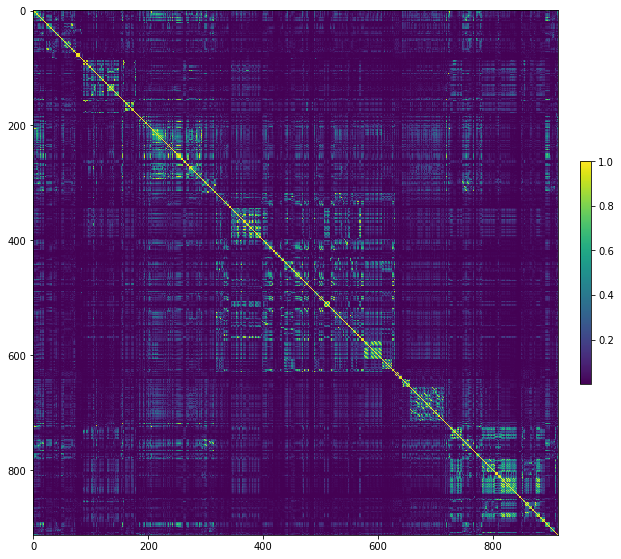

In [125]:
plt.figure(figsize=(10,10))
#im = plt.imshow(corr_def,cmap=plt.cm.viridis)
im = plt.imshow(abs(correlation_num),cmap=plt.cm.viridis)
plt.colorbar(im,fraction=0.02, pad=0.04)

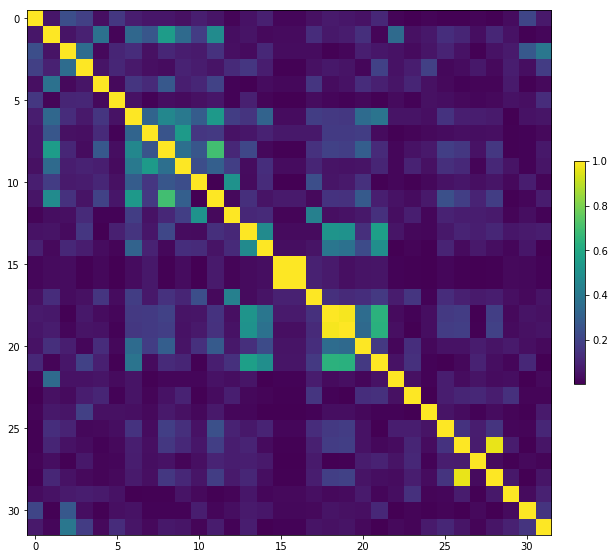

In [126]:
plt.figure(figsize=(10,10))
#im = plt.imshow(corr_def,cmap=plt.cm.viridis)
im = plt.imshow(abs(correlation_cat),cmap=plt.cm.viridis)
plt.colorbar(im,fraction=0.02, pad=0.04)

In [127]:
result_tab_cat, non_doubles_cat, col_doubles_cat, double_dic_cat = find_doubles_corr(data, columns, correlation_cat, 
                                                            definition = None, lvl = 0.90, light_unstable = light_unstable)

result_tab_num, non_doubles_num, col_doubles_num, double_dic_num = find_doubles_corr(data, columns, correlation_num, 
                                                            definition = None, lvl = 0.90, light_unstable = light_unstable)

Порог = 0.9 Осталось фичей = 29 Коррелир.фичей = 3
Порог = 0.9 Осталось фичей = 539 Коррелир.фичей = 374


In [128]:
result_tab_num.to_csv(PATH + 'Selection/SandBox/result_tab_num.csv')
result_tab_cat.to_csv(PATH + 'Selection/SandBox/result_tab_cat.csv')

In [129]:
for i in col_doubles_cat + col_doubles_num:
    if i not in COL_DEL and i not in necessary_fields_upper:
        print(i)
        COL_DEL.append(i)

REFERANYANALYST_AD
DENY_AD
TYPELASTCALL_12
MOB_O
MAXMOBOPENEVER_O
MINMOBOPENEVER_O
COUNTOFPAYMENTSEVER_O
PAYAMTEVER_O
PAYAMTL24M_O
TRANSNUML6M_O
TRANSNUML9M_O
TRANSNUML12M_O
TRANSSUML9M_O
TRANSSUML12M_O
PAYCMTOPAYL6M_O
TRANSNUMCMTOTRANSNUML6M_O
TRANSSUMCMTOTRANSSUML3M_O
TRANSSUMCMTOTRANSSUML6M_O
TRANSSUMCMTOTRANSSUML12M_O
TRANSSUML3MTOTRANSSUML6M_O
TRANSSUML3MTOTRANSSUML12M_O
TRANSSUML3MTOAVGLIMITL3M_O
TRANSSUML6MTOAVGLIMITL6M_O
TRANSSUML12MTOAVGLIMITL12M_O
TRANSAVGAMOUNTL3M_O
TRANSAVGAMOUNTL6M_O
CASHL3MTOALLL3M_O
CASHL6MTOALLL6M_O
CASHL12MTOALLL12M_O
CASHCMTOBALANCECM_O
CASHCMTOBALANCE03_O
CASHCMTOAVGLIMITL3M_O
MAXDAYSINDELINQL6M_B
MAXDAYSINDELINQL12M_B
MAXDAYSINDELINQL24M_B
SUMDELINQLENGHTL3M_B
SUMDELINQLENGHTL6M_B
SUMDELINQLENGHTL12M_B
SUMDELINQLENGHTL24M_B
COUNT60PEVER_B
COUNT90PEVER_B
LENGTHOFLASTDELINQEVER_B
MAXOVERDUETOLIMITL6M_B
MAXOVERDUETOLIMITL12M_B
MAXOVERDUETOBALANCEL3M_B
MAXOVERDUETOBALANCEL6M_B
MAXOVERDUEAMOUNTL12M_B
MAXOVERDUE30PEVER_B
MAXOVERDUE00PL12M_B
AVGOVERDUE30PE

In [130]:
data.head()

UNNAMED: 0      CIF_ID  FUNDEDAMT_O  COUNTPAIDOUT_O  MOB_O  \
0           0  1000000653    167508.88             2.0    4.0   
1           1  1000002153          NaN             NaN    NaN   
2           2  1000002599     63832.62             1.0    3.0   
3           3  1000002599     63832.62             1.0    5.0   
4           6  1000003476          NaN             NaN    NaN   

   MAXMOBOPENEVER_O  MINMOBOPENEVER_O  MAXMOBOPENEVER_ALL_O  MOBC_ALL_O  \
0               4.0               4.0                   4.0         4.0   
1               NaN               NaN                   NaN         NaN   
2               3.0               3.0                  25.0        28.0   
3               5.0               5.0                  25.0        30.0   
4               NaN               NaN                   NaN         NaN   

   MINMOBOPENEVER_ALL_O  ...  FLAG_CLIENT_AGENCY_12M   AGE  PRSEDULEVEL  \
0                   NaN  ...                       0  47.0          4.0   
1                   NaN  ...                       0   NaN          NaN   
2                   3.0  ...                       0  40.0          NaN   
3                   5.0  ...                       0  40.0          NaN   
4                   NaN  ...                       0   NaN          NaN   

   EMPINCOMEAMT  EMPINDUSTRY  CCDLOANRATE  REGION_HOME  MONTH_CALL  GOOD_FLAG  \
0       55000.0          6.0          NaN         26.0      201911          0   
1           NaN          NaN          NaN          NaN      201911          0   
2       31000.0         99.0        10.33         25.0      201911          0   
3       31000.0         99.0        10.33         25.0      202001          0   
4           NaN          NaN          NaN          NaN      201911          0   

   MONTH_CALL_GROSS  
0          201911.0  
1          201911.0  
2          201911.0  
3          202001.0  
4          201911.0  

[5 rows x 1227 columns]

In [131]:
# Recording deleted
deleted = pd.DataFrame({'feature': col_doubles_cat + col_doubles_num})
deleted.insert(1, 'reason', 'doubles')


In [132]:
# Record remaining
stay6 = pd.DataFrame({'feature': columns})

In [133]:
file_name = PATH + 'Selection/excel/8. f_double_d_bef_bin.xlsx'
deleted.to_excel(file_name, index = False)

In [134]:
file_name = PATH + 'Selection/excel/9. f_double_s_bef_bin.xlsx'
stay6.to_excel(file_name, index = False)

In [135]:
file_name = PATH + 'Selection/excel/12. COR_NUM.xlsx'
correlation_num.to_excel(file_name)
file_name = PATH + 'Selection/excel/12. COR_CAT.xlsx'
correlation_cat.to_excel(file_name)

In [137]:
columns = [i for i in data.columns if i not in COL_DEL]

In [138]:
len(columns)

571

In [139]:
attribute_list_for_bin = attributes_list_new(data, columns)

Строим атрибут-лист
[0.01 0.02 0.05 0.95 0.98 0.99]
Number of finished repetitions: 0 | time:  10.03.2020 21:21:02
Number of finished repetitions: 100 | time:  10.03.2020 21:21:19
Number of finished repetitions: 200 | time:  10.03.2020 21:21:42
Number of finished repetitions: 300 | time:  10.03.2020 21:21:57
Number of finished repetitions: 400 | time:  10.03.2020 21:22:10
Number of finished repetitions: 500 | time:  10.03.2020 21:22:34
Атрибут-лист готов


In [140]:
attribute_list_for_bin.sort_values('max_val').tail(10)

attribute type_val  count_dist  count_miss      moda_val  \
354       SUMREPAIDNOBAL_C  float64      218370       29873  0.000000e+00   
347       SUMREPAIDACTIV_C  float64      164841       69458  0.000000e+00   
290            SUMREPAID_C  float64      233422       17062  0.000000e+00   
0                   CIF_ID    int64      252086           0  1.039381e+09   
566           EMPINCOMEAMT  float64        2638       21656  3.000000e+04   
127           CCDAMTREQ_AA  float64       70015        3734  3.000000e+04   
239       UNUSEDLIMCCMIN_C  float64       11972      204811  0.000000e+00   
238       UNUSEDLIMCCMAX_C  float64       14084      204811  0.000000e+00   
134  PURCHASEAMOUNT_MAX_AA  float64       46954       20156  3.000000e+04   
114   TOTAL_INCOME_CURR_AP  float64        4040        6239  3.000000e+04   

     count_value_moda  count_val          mean   stand_d_val       min_val  \
354              4676   273347.0  8.308164e+05  4.330989e+06  0.000000e+00   
347              7743   233762.0  4.093922e+05  4.133746e+06  0.000000e+00   
290              3018   286158.0  1.154359e+06  5.836420e+06  0.000000e+00   
0                   9   303220.0  1.023776e+09  1.298529e+07  1.000000e+09   
566             26623   281564.0  7.872834e+04  1.435355e+07  0.000000e+00   
127            124886   299486.0  1.066768e+05  1.805855e+07  0.000000e+00   
239             10252    98409.0  5.028227e+06  5.311629e+08  0.000000e+00   
238             10252    98409.0  4.189809e+07  2.708572e+09  0.000000e+00   
134             41969   283064.0  4.557308e+06  2.096679e+09  0.000000e+00   
114             20715   296981.0  3.750485e+07  2.038888e+10  0.000000e+00   

               1%            2%            5%   val_mediana           95%  \
354  0.000000e+00  3.207175e+03  1.634442e+04  3.606300e+05  2.772352e+06   
347  0.000000e+00  0.000000e+00  3.120000e+03  1.509525e+05  1.393489e+06   
290  0.000000e+00  7.499000e+03  2.238300e+04  5.474075e+05  3.740861e+06   
0    1.000582e+09  1.001020e+09  1.002171e+09  1.025564e+09  1.039880e+09   
566  0.000000e+00  8.000000e+03  1.200000e+04  3.500000e+04  1.000000e+05   
127  1.000000e+03  1.000000e+03  6.871000e+03  3.000000e+04  3.000000e+05   
239  0.000000e+00  0.000000e+00  0.000000e+00  3.000000e+04  3.640000e+05   
238  0.000000e+00  0.000000e+00  0.000000e+00  9.063000e+04  1.250000e+06   
134  5.967708e+03  7.085000e+03  9.949310e+03  5.000000e+04  5.210000e+05   
114  8.000000e+03  1.000000e+04  1.500000e+04  4.000000e+04  1.100000e+05   

              98%           99%       max_val  
354  4.424460e+06  6.269297e+06  1.446963e+09  
347  2.399143e+06  3.562676e+06  1.453718e+09  
290  5.961361e+06  8.366293e+06  1.465206e+09  
0    1.040408e+09  1.040619e+09  2.147003e+09  
566  1.300000e+05  1.600000e+05  7.000075e+09  
127  7.000000e+05  1.000000e+06  9.882334e+09  
239  8.013180e+05  1.487060e+06  9.000000e+10  
238  3.201458e+06  1.029031e+07  6.068410e+11  
134  7.000000e+05  1.000000e+06  1.111111e+12  
114  1.500000e+05  2.000000e+05  1.111111e+13

In [142]:
for_delete = [i for i in data.columns if i not in columns and i not in necessary_fields_upper]

In [143]:
for i in necessary_fields_upper:
    if i in for_delete:
        print(i)

In [144]:
len(columns)

571

In [145]:
data.drop(for_delete, axis = 1, inplace = True)

In [146]:
data.shape

(303220, 571)

In [147]:
data.head()

CIF_ID  FUNDEDAMT_O  COUNTPAIDOUT_O  MAXMOBOPENEVER_ALL_O  MOBC_ALL_O  \
0  1000000653    167508.88             2.0                   4.0         4.0   
1  1000002153          NaN             NaN                   NaN         NaN   
2  1000002599     63832.62             1.0                  25.0        28.0   
3  1000002599     63832.62             1.0                  25.0        30.0   
4  1000003476          NaN             NaN                   NaN         NaN   

   COUNTOFPAYMENTSL24M_O  COUNTOFPAYMENTSL12M_O  COUNTOFPAYMENTSL6M_O  \
0                    4.0                    4.0                   4.0   
1                    NaN                    NaN                   NaN   
2                    3.0                    3.0                   3.0   
3                    5.0                    5.0                   5.0   
4                    NaN                    NaN                   NaN   

   COUNTOFPAYMENTSL3M_O  COUNTOFPAYMENTSCM_O  ...  \
0                   3.0                  1.0  ...   
1                   NaN                  NaN  ...   
2                   3.0                  1.0  ...   
3                   3.0                  1.0  ...   
4                   NaN                  NaN  ...   

   C_SCHEDULE2FACTPAY1M_ACTIVE  C_COUNTDAYSTASKL3M  C_COUNTOPERATORCALLL3M  \
0                          NaN                   0                       0   
1                          NaN                   0                       0   
2                     1.037646                   0                       0   
3                     2.075292                   0                       0   
4                          NaN                   0                       0   

    AGE  PRSEDULEVEL  EMPINCOMEAMT  EMPINDUSTRY  CCDLOANRATE  MONTH_CALL  \
0  47.0          4.0       55000.0          6.0          NaN      201911   
1   NaN          NaN           NaN          NaN          NaN      201911   
2  40.0          NaN       31000.0         99.0        10.33      201911   
3  40.0          NaN       31000.0         99.0        10.33      202001   
4   NaN          NaN           NaN          NaN          NaN      201911   

   GOOD_FLAG  
0          0  
1          0  
2          0  
3          0  
4          0  

[5 rows x 571 columns]

In [148]:
print_log('start make_standard')
data, changes = make_standard(data, columns, target, attribute_list_for_bin, technical_list = COL_SYS, 
                               categorial_list = categorial_columns, label_encoder = le, 
                 string_list = str_columns, mis_value = missing_strings, small_treshold = 10)
print_log('end make_standard')

start make_standard
PRSMRTLSTSTYPE_AP
PRSMRTLSTSTYPE_AP | count_bin =  5 | del_bin =  0
PRSREGCHECKBOX_AP
PRSREGCHECKBOX_AP | count_bin =  2 | del_bin =  0
TEL_WORK_FLAG_AP
TEL_WORK_FLAG_AP | count_bin =  2 | del_bin =  0
INCTYPE_AP
INCTYPE_AP_7.0 7
INCTYPE_AP_13.0 9
INCTYPE_AP_16.0 3
INCTYPE_AP | count_bin =  17 | del_bin =  3
TEL_REG_FLAG_AP
TEL_REG_FLAG_AP | count_bin =  2 | del_bin =  0
GENDER_AP
GENDER_AP | count_bin =  2 | del_bin =  0
COMBI_OFFER_FLAG_AA
COMBI_OFFER_FLAG_AA | count_bin =  2 | del_bin =  0
COMBI_ISSUE_FLAG_AA
COMBI_ISSUE_FLAG_AA | count_bin =  2 | del_bin =  0
APPISOFFLINE_AA
APPISOFFLINE_AA | count_bin =  2 | del_bin =  0
CCDCREDITPOINT_AA
CCDCREDITPOINT_AA_6.0 4
CCDCREDITPOINT_AA_12.0 6
CCDCREDITPOINT_AA | count_bin =  22 | del_bin =  2
PDSGOODSCAT_MAX_AA
PDSGOODSCAT_MAX_AA_7.0 6
PDSGOODSCAT_MAX_AA_12.0 2
PDSGOODSCAT_MAX_AA_20.0 3
PDSGOODSCAT_MAX_AA_22.0 3
PDSGOODSCAT_MAX_AA_30.0 7
PDSGOODSCAT_MAX_AA_53.0 6
PDSGOODSCAT_MAX_AA_70.0 6
PDSGOODSCAT_MAX_AA_72.0 4
PD

In [149]:
data.shape

(303220, 1214)

In [150]:
changes.to_csv(PATH + 'Selection/SandBox/changes.csv', sep = '&')

In [151]:
changes.head()

new variable   genuine variable  rule values
0  PRSMRTLSTSTYPE_AP_1.0  PRSMRTLSTSTYPE_AP  _1.0      1
1  PRSMRTLSTSTYPE_AP_2.0  PRSMRTLSTSTYPE_AP  _2.0      2
2  PRSMRTLSTSTYPE_AP_3.0  PRSMRTLSTSTYPE_AP  _3.0      3
3  PRSMRTLSTSTYPE_AP_4.0  PRSMRTLSTSTYPE_AP  _4.0      4
4  PRSMRTLSTSTYPE_AP_5.0  PRSMRTLSTSTYPE_AP  _5.0      5

In [152]:
new_bins = changes['new variable'].to_list()

In [153]:
gc.collect()

430

In [154]:
print_log('Строим атрибут-лист')
attribute_list_2 = attributes_list_new(data, data.columns)
print_log('Атрибут-лист готов')

Строим атрибут-лист
[0.01 0.02 0.05 0.95 0.98 0.99]
Number of finished repetitions: 0 | time:  10.03.2020 21:28:16
Number of finished repetitions: 100 | time:  10.03.2020 21:28:36
Number of finished repetitions: 200 | time:  10.03.2020 21:28:58
Number of finished repetitions: 300 | time:  10.03.2020 21:29:12
Number of finished repetitions: 400 | time:  10.03.2020 21:29:26
Number of finished repetitions: 500 | time:  10.03.2020 21:29:47
Number of finished repetitions: 600 | time:  10.03.2020 21:30:03
Number of finished repetitions: 700 | time:  10.03.2020 21:30:14
Number of finished repetitions: 800 | time:  10.03.2020 21:30:30
Number of finished repetitions: 900 | time:  10.03.2020 21:30:49
Number of finished repetitions: 1000 | time:  10.03.2020 21:31:08
Number of finished repetitions: 1100 | time:  10.03.2020 21:31:21
Number of finished repetitions: 1200 | time:  10.03.2020 21:31:35
Атрибут-лист готов


In [155]:
if hyper_disbalance== False:
    
    attribute_list_1_eq_99_2 =attribute_list_2[(attribute_list_2['1%'] == attribute_list_2['99%'])]

    check_1_eq_99_2 = check_attribute_list_cases(data, attribute_list_1_eq_99_2, target.upper(), task = task)

    left_vars= check_1_eq_99_2.loc[(check_1_eq_99_2['Count_1'] >= data.shape[0]*0.005) & 
                     (check_1_eq_99_2['Count_2'] >= data.shape[0]*0.005) &
                     (check_1_eq_99_2['p_value'] <= 0.05), 'attribute'].to_list()

    attribute_list_1_eq_99_to_delete_2 = attribute_list_1_eq_99_2#[~attribute_list_1_eq_99_2.isin(left_vars)]

In [156]:
if hyper_disbalance== False:
    attribute_list_one_value_2 =  attribute_list_2[attribute_list_2['count_dist'] == 1]

    check_one_value_2 = check_attribute_list_cases(data, attribute_list_one_value_2, target.upper(), task = task)

    left_vars_one_val= check_one_value_2.loc[(check_one_value_2['Count_1'] >= data.shape[0]*0.005) & 
                     (check_one_value_2['Count_2'] >= data.shape[0]*0.005) &
                     (check_one_value_2['p_value'] <= 0.05), 'attribute'].to_list()

    attribute_list_one_value_for_delete_2 = attribute_list_one_value_2#[~attribute_list_one_value_2.isin(left_vars_one_val)]

In [157]:
if hyper_disbalance== False:
    deleted = pd.DataFrame({'feature': [], 'reason': []})
    deleted = deleted.append(features_for_delete(attribute_list_1_eq_99_to_delete_2,'1_perc_eq_99_perc_after_bin'), 
                             ignore_index = True)

    deleted = deleted.append(features_for_delete(attribute_list_one_value_for_delete_2,'one_value_after_bin'), 
                             ignore_index = True)

In [158]:
if hyper_disbalance== False:
    for i in attribute_list_1_eq_99_to_delete_2['attribute'].to_list():
        if i not in COL_DEL and i not in necessary_fields_upper:
            COL_DEL.append(i)

    for i in attribute_list_one_value_for_delete_2['attribute'].to_list():
        if i not in COL_DEL and i not in necessary_fields_upper:
            COL_DEL.append(i)

In [159]:
if hyper_disbalance== False:
    for i in necessary_fields_upper:
        if i in COL_DEL:
            print(i)

In [160]:
attribute_list_2.to_csv(PATH + 'Selection/SandBox/attribute_list_var_binned.csv', sep='&')
if hyper_disbalance== False:
    file_name = PATH + 'Selection/excel/6. BL_Разведочная_Статистика_после_Биннинга.xlsx'
    deleted.to_excel(file_name, index = False)

In [161]:
categorial_columns = list(set(categorial_columns+new_bins))

In [162]:
COL_TRG = target.upper()

In [163]:
gc.collect()

81

In [164]:
categorial_data = pd.DataFrame(categorial_columns)
del_data = pd.DataFrame(COL_DEL)
sys_data = pd.DataFrame(COL_SYS)

In [165]:
categorial_data.rename(columns = {0:'variable'}, inplace = True)
del_data.rename(columns = {0:'variable'}, inplace = True)
sys_data.rename(columns = {0:'variable'}, inplace = True)

In [166]:
categorial_data.to_csv(PATH+'Selection/SandBox/categorial_data.csv', sep='&')
sys_data.to_csv(PATH+'Selection/SandBox/sys_data.csv', sep='&')
del_data.to_csv(PATH+'Selection/SandBox/del_data.csv', sep='&')

In [167]:
file_name = PATH+'Data Sets/train_binned.csv'
data.to_csv(file_name, sep = '&', encoding = 'cp1251')

In [171]:
gc.collect()

0

In [172]:
print_log('Start preprocessing')
data = data_preprocessing_train(data, COL_TRG, 
                                technical_values = [COL_SYS+necessary_fields_upper], 
                                drop_technical = False,
                                yeo_johnson = False, 
                                attribute_list = None, 
                                var_col = None,
                                scale = False, 
                                median = 'median',
                                high_outlier = None, 
                                low_outlier = None, 
                                cols_outlier = None)


Start preprocessing


### Correlation with target (after binning)

In [173]:
columns = [c for c in data.columns if c not in COL_DEL]

In [174]:
len(data.columns), len(columns)

(1214, 1033)

In [175]:
len(categorial_columns)

709

In [176]:
target = target.upper()

In [177]:
definition_2 = statistics_with_target(data, columns, target, category_list = categorial_columns)

Number of finished repetitions: 30 | time:  10.03.2020 21:39:54
Number of finished repetitions: 60 | time:  10.03.2020 21:40:14
Number of finished repetitions: 90 | time:  10.03.2020 21:40:36
Number of finished repetitions: 120 | time:  10.03.2020 21:40:48
Number of finished repetitions: 150 | time:  10.03.2020 21:41:04
Number of finished repetitions: 180 | time:  10.03.2020 21:41:16
Number of finished repetitions: 210 | time:  10.03.2020 21:41:38
Number of finished repetitions: 240 | time:  10.03.2020 21:41:53
Number of finished repetitions: 270 | time:  10.03.2020 21:42:10
Number of finished repetitions: 300 | time:  10.03.2020 21:42:27
Number of finished repetitions: 330 | time:  10.03.2020 21:42:50
Number of finished repetitions: 360 | time:  10.03.2020 21:43:05
Number of finished repetitions: 390 | time:  10.03.2020 21:43:11
Number of finished repetitions: 420 | time:  10.03.2020 21:43:30
Number of finished repetitions: 450 | time:  10.03.2020 21:43:47
Number of finished repetitio

In [178]:
definition_2.sort_values(by = 'corr', ascending = False)

variable    stat pvalue      corr corr name
541                   GOOD_FLAG   0.000000e+00  0.707063       phi
458                 C_COUNTOFGP   0.000000e+00  0.071528      corr
137            R_CNT_ALL_GP_REP  3.172513e-168  0.048999      corr
143           R_CNT_OPEN_GP_REP  2.695740e-150  0.047714      corr
1                   FUNDEDAMT_O  1.817122e-163  0.047324      corr
937         VERYNEGTOALL_12_bin  5.355990e-150  0.047318       phi
928    COUNTVERYNEGATIVE_12_bin  5.355990e-150  0.047318       phi
437        C_COUNTOFPAYMENTSL3M  7.380038e-136  0.046854      corr
574     PDSGOODSCAT_MAX_AA_57.0  5.107718e-145  0.046517       phi
145           R_CNT_OPEN_CC_REP  3.588686e-140  0.046004      corr
804        UNUSEDLIMCCMIN_C_bin  7.955451e-132  0.044324       phi
803        UNUSEDLIMCCMAX_C_bin  7.955451e-132  0.044324       phi
948    COUNTVERYNEGATIVE_24_bin  1.105550e-130  0.044129       phi
955         VERYNEGTOALL_24_bin  1.105550e-130  0.044129       phi
732     PRODUCT_PTI_FACT_AD_bin  4.864894e-129  0.043847       phi
399      POSTOALLWITHCN_2020_12  4.524755e-165  0.043788      corr
522                 C_PLANPAY3M  2.049931e-139  0.043751      corr
525          C_PLANPAY6M_ACTIVE  5.469813e-164  0.043714      corr
562         APPISOFFLINE_AA_0.0  5.537614e-128  0.043665       phi
456         C_COUNTALLCONTRACTS  2.597667e-119  0.043644      corr
563         APPISOFFLINE_AA_1.0  4.780375e-127  0.043502       phi
567      CCDCREDITPOINT_AA_22.0  3.815308e-126  0.043345       phi
129              INTERNALPMT_AD  4.829466e-130  0.043187      corr
413           POSTOALLWITHCN_24  3.760246e-165  0.043155      corr
136      COUNTPREVCONTR_0PL_REP  2.625042e-121  0.042657      corr
142          R_CNT_OPEN_ALL_REP   9.972463e-87  0.042415      corr
526         C_PLANPAY12M_ACTIVE  6.629726e-152  0.042275      corr
414     SUMPOSNEUTOALLWITHCN_24  1.202687e-125  0.042184      corr
355                   INQ_NMB_C  1.107646e-130  0.042097      corr
886        AMTOPNWBCC_MIN_C_bin  2.143691e-115  0.041430       phi
..                          ...            ...       ...       ...
32       SUMPAYMENTL3MTOLIMIT_O   5.114713e-42 -0.007365      corr
205            SINCELSTOPENCC_C   5.399568e-15 -0.009534      corr
391               SUMONLYNEG_12   2.681448e-09 -0.010931      corr
455      C_MONTHSINCELASTCREDIT   2.615772e-12 -0.011177      corr
373             C_COUNTALLSMS6M   4.956437e-16 -0.012606      corr
372             C_COUNTALLSMS3M   1.391687e-13 -0.012641      corr
246               TERMAPR_MIN_C   2.456368e-13 -0.012774      corr
122          PDSNBRUNITS_SUM_AA   4.469148e-30 -0.012879      corr
416         NOCONT2ALLWITHCN_24   3.928325e-17 -0.013229      corr
103         CCARDMAXUTILLL24M_B   4.801042e-02 -0.013249      corr
0                        CIF_ID   2.511567e-21 -0.014676      corr
42            PAYL6MTOPAYL12M_O   6.324259e-20 -0.014756      corr
444      C_SUMOFPAYMENTSL3M2L6M   2.349118e-19 -0.017385      corr
269               OW_REPORTDT_C   1.177629e-58 -0.017662      corr
30   SUMPAYMENTL6MTOLIMITCARD_O   7.388793e-02 -0.020671      corr
203              SINCELSTOPEN_C   8.213868e-36 -0.021100      corr
402            COUNTNEGATIVE_24   1.617739e-27 -0.021216      corr
400      NEGTOALLWITHCN_2020_12   7.378373e-36 -0.021389      corr
39             PAYCMTOPAYL12M_O   1.276113e-67 -0.021888      corr
401  VERYNEGTOALLWITHCN_2020_12   1.835119e-37 -0.023763      corr
459                 C_COUNTOFIL   5.365322e-44 -0.023988      corr
41            PAYL3MTOPAYL12M_O   2.285075e-88 -0.029563      corr
397        VERYNEGTOALL_2020_12   9.352036e-63 -0.030503      corr
40             PAYL3MTOPAYL6M_O   2.226319e-55 -0.031176      corr
415           NEGTOALLWITHCN_24   3.351077e-76 -0.032495      corr
17           SUMPAYCMTOMAXPAY_O   1.047675e-72 -0.034803      corr
125                PTI_FINAL_AD  1.323167e-210 -0.037811      corr
392                 NEGTOALL_12  2.699408e-134 -0.044836      corr
410

In [179]:
definition_2[definition_2['stat pvalue'] > 0.05].head()

variable  stat pvalue      corr corr name
30  SUMPAYMENTL6MTOLIMITCARD_O     0.073888 -0.020671      corr
33      SUMPAYMENTL6MTOLIMIT_O     0.487183  0.002049      corr
38       PAYL12MTOSUMBALL12M_O     0.421281  0.000547      corr
59        MAXDAYSINDELINQL3M_B     0.136868  0.004006      corr
65                COUNT00P6M_B     0.218202  0.001016      corr

In [180]:
not_imp = definition_2[definition_2['stat pvalue'] > 0.05]['variable'].to_list()
print(len(not_imp))

104


In [181]:
definition_2.to_csv(PATH + 'Selection/SandBox/definition_2.csv')

In [182]:
for i in not_imp:
    if i not in COL_DEL and i not in necessary_fields_upper:
        #print(i)
        COL_DEL.append(i)
columns = [i for i in data.columns if i not in COL_DEL]        
len(columns), len(COL_DEL) 

(929, 968)

In [183]:
for i in necessary_fields_upper:
    if i in COL_DEL:
        print(i)

In [184]:
deleted = pd.DataFrame({'feature': not_imp})
deleted.insert(1, 'reason', 'target_after_bin')

In [185]:
columns = [c for c in data.columns if c not in COL_DEL]
stay7 = pd.DataFrame({'feature': columns})
stay7.head()

feature
0                CIF_ID
1           FUNDEDAMT_O
2        COUNTPAIDOUT_O
3  MAXMOBOPENEVER_ALL_O
4            MOBC_ALL_O

In [186]:
file_name = PATH + 'Selection/excel/10. f_target_d_aft_bin.xlsx'
deleted.to_excel(file_name, index = False)

In [187]:
file_name = PATH + 'Selection/excel/11. f_target_s_aft_bin.xlsx'
stay7.to_excel(file_name, index = False)

## Correlation matrix (after binning)

In [189]:
columns = [c for c in data.columns if c not in COL_DEL and c not in necessary_fields_upper]

In [190]:
len(columns), len(data.columns)

(926, 1214)

In [191]:
categorial_columns1 = [c for c in categorial_columns if c not in COL_DEL and c not in necessary_fields_upper and c in data.columns]
len(categorial_columns1)

458

In [192]:
data[categorial_columns1].dropna().shape == data[categorial_columns1].shape

True

In [193]:
categorials_data_fin = pd.DataFrame()
categorials_data_fin['feature'] = categorial_columns1
categorials_data_fin.to_csv(PATH + 'Selection/SandBox/categories_fin.csv', sep = '&')

In [194]:
gc.collect()

176

In [195]:
print_log('Вычисление корреляции на разбинненой выборке - start')
correlation_num1, correlation_cat1 = receive_correlations(data[columns], categorial_list = categorial_columns1)
print_log('Вычисление корреляции на разбинненой выборке - end')

Вычисление корреляции на разбинненой выборке - start
Начало time:  10.03.2020 21:45:31
Корреляционная матрица по числовым переменным посчитана time:  10.03.2020 21:48:27
Корреляционная матрица по категориальным переменным посчитана time:  11.03.2020 05:07:47
Вычисление корреляции на разбинненой выборке - end


In [196]:
print_log('Поиск дублей - start')
result_tab_cat1, non_doubles_cat1, col_doubles_cat1, double_dic_cat1 = find_doubles_corr(data, columns, 
                                  correlation_cat1, definition = definition_2, lvl = 0.70, light_unstable = None)
result_tab_num1, non_doubles_num1, col_doubles_num1, double_dic_num1 = find_doubles_corr(data, columns, 
                                  correlation_num1, definition = definition_2, lvl = 0.70, light_unstable = None)
print_log('Поиск дублей - end')

Поиск дублей - start
Порог = 0.7 Осталось фичей = 122 Коррелир.фичей = 336
Порог = 0.7 Осталось фичей = 269 Коррелир.фичей = 199
Поиск дублей - end


In [197]:
result_tab_num1.to_csv(PATH + 'Selection/SandBox/result_tab_num_binned.csv', sep = '&')
result_tab_cat1.to_csv(PATH + 'Selection/SandBox/result_tab_cat_binned.csv', sep = '&')

In [198]:
non_doubles1 = list(set(non_doubles_cat1 + non_doubles_num1))

In [199]:
len(non_doubles1)

391

In [200]:
pd_non_doubles1 = pd.DataFrame()
pd_non_doubles1['val'] = non_doubles1
pd_non_doubles1.to_csv(PATH + 'Selection/SandBox/non_doubles_binned.csv', sep = '&')

In [201]:
file_name = PATH + 'Selection/excel/12. COR_NUM_binned.xlsx'
correlation_num1.to_excel(file_name)
file_name = PATH + 'Selection/excel/12. COR_CAT_binned.xlsx'
correlation_cat1.to_excel(file_name)

In [202]:
for i in col_doubles_cat1 + col_doubles_num1:
    if i not in COL_DEL and i not in necessary_fields_upper:
#        print(i)
        COL_DEL.append(i)
columns = [i for i in data.columns if i not in COL_DEL]
len(columns), len(COL_DEL) 


(394, 1503)

In [203]:
columns = [i for i in data.columns if i not in COL_DEL]
len(columns), len(COL_DEL) 

(394, 1503)

In [204]:
#Записываем удаленные
deleted = pd.DataFrame({'feature': col_doubles_cat1 + col_doubles_num1})
deleted.insert(1, 'reason', 'doubles_after_bin')

#Записываем оставшиеся
stay13 = pd.DataFrame({'feature': columns})

In [205]:
print(stay13.shape)
stay13.head()

(394, 1)


feature
0                CIF_ID
1  COUNTOFPAYMENTSL6M_O
2   MAXPTIEVER_ACTUAL_O
3          MAXPTIEVER_O
4    SUMPAYCMTOMAXPAY_O

**12	f_double_d_aft_bin**	Переменные, удаленные после оценки статистики с целевой после расчета бинов

In [206]:
file_name = PATH + 'Selection/excel/12. f_double_d_aft_bin.xlsx'
deleted.to_excel(file_name, index = False)

In [207]:
file_name = PATH + 'Selection/excel/13. f_double_s_aft_bin.xlsx'
stay13.to_excel(file_name, index = False)

## TwoForests 

In [210]:
columns = [i for i in data.columns if i not in COL_DEL]
deleted = [i for i in data.columns if i not in columns]

In [211]:
len(columns)

394

In [212]:
for i in necessary_fields_upper:
    if i not in columns:
        print(i)

In [213]:
data.drop(deleted, axis = 1, inplace = True)

In [214]:
data.shape

(303220, 394)

In [215]:
data.head()

CIF_ID  COUNTOFPAYMENTSL6M_O  MAXPTIEVER_ACTUAL_O  MAXPTIEVER_O  \
0  1000000653                   4.0             0.233347      0.353232   
1  1000002153                   6.0             0.357143      0.500000   
2  1000002599                   3.0             0.334041      0.339517   
3  1000002599                   5.0             0.334041      0.339517   
4  1000003476                   6.0             0.357143      0.500000   

   SUMPAYCMTOMAXPAY_O  TRANSNUML3M_O  TRANSSUML6M_O  CASHL1M_O  CASHL3M_O  \
0            1.000000            0.0          100.0        0.0        0.0   
1            0.333333            0.0          100.0        0.0        0.0   
2            0.096569            0.0          100.0        0.0        0.0   
3            0.096569            0.0          100.0        0.0        0.0   
4            0.333333            0.0          100.0        0.0        0.0   

   CASHL6M_O  ...  C_DAYSBETWLASTDELINQS12M_bin  \
0        0.0  ...                             0   
1        0.0  ...                             0   
2        0.0  ...                             0   
3        0.0  ...                             1   
4        0.0  ...                             0   

   C_COUNTOFPAYMENTS2AMONTHSL1M_bin  C_DAYSSINCELASTTPC12M_bin  \
0                                 0                          0   
1                                 0                          0   
2                                 1                          0   
3                                 1                          0   
4                                 0                          0   

   C_DAYSSINCELASTINBOUNDALLL12M_bin  C_DAYSSINCELASTOUTBOUNDL6M_bin  \
0                                  0                               0   
1                                  0                               0   
2                                  0                               1   
3                                  0                               1   
4                                  0                               0   

   C_MAXDAYSTORPCALL12M_bin  C_COUNTIN2COUNTOUTALLL3M_CL_bin  \
0                         0                                0   
1                         0                                0   
2                         0                                0   
3                         0                                0   
4                         0                                0   

   C_COUNTIN2COUNTOUTALLL12M_CL_bin  C_SCHEDULE2FACTPAY1M_bin  \
0                                 0                         0   
1                                 0                         0   
2                                 1                         1   
3                                 1                         1   
4                                 0                         0   

   EMPINCOMEAMT_bin  
0                 1  
1                 0  
2                 1  
3                 1  
4                 0  

[5 rows x 394 columns]

In [216]:
for i in COL_SYS:
    if i in list(data.columns) and i not in necessary_fields_upper:
        print(i)
        data.drop(i, axis = 1, inplace = True)

In [217]:
for i in necessary_fields_upper:
    if i not in data.columns:
        print(i)

In [218]:
file_name = PATH+'Data Sets/train_for_forest.csv'
data.to_csv(file_name, sep = '&', encoding = 'cp1251')

In [220]:
target = target.upper()

In [221]:
data.head()

CIF_ID  COUNTOFPAYMENTSL6M_O  MAXPTIEVER_ACTUAL_O  MAXPTIEVER_O  \
0  1000000653                   4.0             0.233347      0.353232   
1  1000002153                   6.0             0.357143      0.500000   
2  1000002599                   3.0             0.334041      0.339517   
3  1000002599                   5.0             0.334041      0.339517   
4  1000003476                   6.0             0.357143      0.500000   

   SUMPAYCMTOMAXPAY_O  TRANSNUML3M_O  TRANSSUML6M_O  CASHL1M_O  CASHL3M_O  \
0            1.000000            0.0          100.0        0.0        0.0   
1            0.333333            0.0          100.0        0.0        0.0   
2            0.096569            0.0          100.0        0.0        0.0   
3            0.096569            0.0          100.0        0.0        0.0   
4            0.333333            0.0          100.0        0.0        0.0   

   CASHL6M_O  ...  C_DAYSBETWLASTDELINQS12M_bin  \
0        0.0  ...                             0   
1        0.0  ...                             0   
2        0.0  ...                             0   
3        0.0  ...                             1   
4        0.0  ...                             0   

   C_COUNTOFPAYMENTS2AMONTHSL1M_bin  C_DAYSSINCELASTTPC12M_bin  \
0                                 0                          0   
1                                 0                          0   
2                                 1                          0   
3                                 1                          0   
4                                 0                          0   

   C_DAYSSINCELASTINBOUNDALLL12M_bin  C_DAYSSINCELASTOUTBOUNDL6M_bin  \
0                                  0                               0   
1                                  0                               0   
2                                  0                               1   
3                                  0                               1   
4                                  0                               0   

   C_MAXDAYSTORPCALL12M_bin  C_COUNTIN2COUNTOUTALLL3M_CL_bin  \
0                         0                                0   
1                         0                                0   
2                         0                                0   
3                         0                                0   
4                         0                                0   

   C_COUNTIN2COUNTOUTALLL12M_CL_bin  C_SCHEDULE2FACTPAY1M_bin  \
0                                 0                         0   
1                                 0                         0   
2                                 1                         1   
3                                 1                         1   
4                                 0                         0   

   EMPINCOMEAMT_bin  
0                 1  
1                 0  
2                 1  
3                 1  
4                 0  

[5 rows x 394 columns]

In [222]:
once_rows = sum(data[target])
second_rows = (len(data[target]) - sum(data[target]))
y_unique = sorted(data[target].unique())
all_rows = len(data[target])

once_rows_share = once_rows/all_rows
second_rows_share = second_rows/all_rows
second_rows_share/once_rows_share

if once_rows < second_rows:
    w_b = once_rows/second_rows
else:
    w_b = second_rows/once_rows

In [223]:
once_rows_share, second_rows_share

(0.013356638744146165, 0.9866433612558538)

In [146]:
w_b

0.013537453621686667

In [225]:
w1 = [  
    {0: round(0.75*w_b, 4), 1: 1},
    {0: round(w_b, 4), 1: 1},
    {0: round(1.5*w_b, 4), 1: 1},
    {0: round(2.5*w_b, 4), 1: 1},
    {0: round(3*w_b, 4), 1: 1},
    {0: round(4*w_b, 4), 1: 1},
    {0: round(5*w_b, 4), 1: 1},
    {0: round(6*w_b, 4), 1: 1}
]

In [226]:
gc.collect()

114

In [227]:
w1

[{0: 0.0102, 1: 1},
 {0: 0.0203, 1: 1},
 {0: 0.0338, 1: 1},
 {0: 0.0406, 1: 1},
 {0: 0.0541, 1: 1},
 {0: 0.0677, 1: 1},
 {0: 0.0812, 1: 1}]

In [228]:
number_of_trees = [1*data.drop(necessary_fields_upper, axis = 1).shape[1], 
                   round(1.10*data.drop(necessary_fields_upper, axis = 1).shape[1]), 
                   round(1.25*data.drop(necessary_fields_upper, axis = 1).shape[1])]
number_of_trees

[391, 430, 489]

**Разделим выборку на 2 равных куска**

In [229]:
if 'Unnamed: 0' in data.columns.to_list():
    data.drop('Unnamed: 0', axis = 1, inplace = True)
    
if 'Unnamed: 0.1' in data.columns.to_list():
    data.drop('Unnamed: 0.1', axis = 1, inplace = True)

In [230]:
data.head()

CIF_ID  COUNTOFPAYMENTSL6M_O  MAXPTIEVER_ACTUAL_O  MAXPTIEVER_O  \
0  1000000653                   4.0             0.233347      0.353232   
1  1000002153                   6.0             0.357143      0.500000   
2  1000002599                   3.0             0.334041      0.339517   
3  1000002599                   5.0             0.334041      0.339517   
4  1000003476                   6.0             0.357143      0.500000   

   SUMPAYCMTOMAXPAY_O  TRANSNUML3M_O  TRANSSUML6M_O  CASHL1M_O  CASHL3M_O  \
0            1.000000            0.0          100.0        0.0        0.0   
1            0.333333            0.0          100.0        0.0        0.0   
2            0.096569            0.0          100.0        0.0        0.0   
3            0.096569            0.0          100.0        0.0        0.0   
4            0.333333            0.0          100.0        0.0        0.0   

   CASHL6M_O  ...  C_DAYSBETWLASTDELINQS12M_bin  \
0        0.0  ...                             0   
1        0.0  ...                             0   
2        0.0  ...                             0   
3        0.0  ...                             1   
4        0.0  ...                             0   

   C_COUNTOFPAYMENTS2AMONTHSL1M_bin  C_DAYSSINCELASTTPC12M_bin  \
0                                 0                          0   
1                                 0                          0   
2                                 1                          0   
3                                 1                          0   
4                                 0                          0   

   C_DAYSSINCELASTINBOUNDALLL12M_bin  C_DAYSSINCELASTOUTBOUNDL6M_bin  \
0                                  0                               0   
1                                  0                               0   
2                                  0                               1   
3                                  0                               1   
4                                  0                               0   

   C_MAXDAYSTORPCALL12M_bin  C_COUNTIN2COUNTOUTALLL3M_CL_bin  \
0                         0                                0   
1                         0                                0   
2                         0                                0   
3                         0                                0   
4                         0                                0   

   C_COUNTIN2COUNTOUTALLL12M_CL_bin  C_SCHEDULE2FACTPAY1M_bin  \
0                                 0                         0   
1                                 0                         0   
2                                 1                         1   
3                                 1                         1   
4                                 0                         0   

   EMPINCOMEAMT_bin  
0                 1  
1                 0  
2                 1  
3                 1  
4                 0  

[5 rows x 394 columns]

In [231]:
print_log('Start stratified_split')
X_1, X_2, y_1, y_2 = stratified_split(data, target, list_of_vars_for_strat_upper, sort_by_var_upper, 
                                      size_of_test = 0.5, drop_technical = True, random_state = 241)
print_log('End stratified_split')

Start stratified_split
End stratified_split


In [232]:
X_1.shape, X_1.dropna().shape

((151581, 391), (151581, 391))

In [233]:
random_params = {'max_depth': 4, 'class_weight': {0: w_b, 1: 1}, 'n_estimators': data.shape[1], 
               'max_features': 0.15, 'min_samples_leaf': 5, 
               'min_samples_split': 10, 'random_state': 241}

In [234]:
rf = RandomForestClassifier(**random_params)
rf.fit(X_1, y_1)
y_pred = rf.predict_proba(X_1)[:,1]
y_pred_test = rf.predict_proba(X_2)[:,1]
av_tr = average_precision_score(y_1, y_pred)
auc_tr = roc_auc_score(y_1, y_pred)

av_t_1 = average_precision_score(y_2, y_pred_test)
auc_t = roc_auc_score(y_2, y_pred_test)
print('First', 'av_train = ', av_tr, 'auc_train = ', auc_tr, '\n')
print('First', 'av_test = ', av_t_1, 'auc_test = ', auc_t, '\n')


rf = RandomForestClassifier(**random_params)
rf.fit(X_2, y_2)
y_pred = rf.predict_proba(X_2)[:,1]
y_pred_test = rf.predict_proba(X_1)[:,1]
av_tr = metrics.average_precision_score(y_2, y_pred)
auc_tr = metrics.roc_auc_score(y_2, y_pred)

av_t_2 = metrics.average_precision_score(y_1, y_pred_test)
auc_t = metrics.roc_auc_score(y_1, y_pred_test)
print('Second', 'av_train = ', av_tr, 'auc_train = ', auc_tr, '\n')
print('Second', 'av_test = ', av_t_2, 'auc_test = ', auc_t, '\n')

First av_train =  0.04579017515947386 auc_train =  0.7463070545047478 

First av_test =  0.031492381815439965 auc_test =  0.7192116943778777 

Second av_train =  0.04246556417208251 auc_train =  0.7473469600714656 

Second av_test =  0.031802297757712227 auc_test =  0.7153639732844467 



In [232]:
grid_params = {'max_depth': [2, 3, 4], 'class_weight': w1, 'n_estimators': number_of_trees, 
               'max_features': [0.15], 'min_samples_leaf': [5], 
               'min_samples_split': [10], 'random_state': [241]}
grid_params

{'max_depth': [2, 3, 4],
 'class_weight': [{0: 0.046, 1: 1},
  {0: 0.0919, 1: 1},
  {0: 0.1532, 1: 1},
  {0: 0.1838, 1: 1},
  {0: 0.2451, 1: 1},
  {0: 0.3063, 1: 1},
  {0: 0.3676, 1: 1}],
 'n_estimators': [368, 405, 460],
 'max_features': [0.15],
 'min_samples_leaf': [5],
 'min_samples_split': [10],
 'random_state': [241]}

In [232]:
scorings = ['average_precision', 'roc_auc']

In [233]:
grid = GridSearchCV(RandomForestClassifier(), grid_params, scoring = scorings, verbose = 20, cv = 3, 
                   refit = 'average_precision')
grid.fit(data.drop(necessary_fields_upper, axis = 1), data[target])

Fitting 3 folds for each of 63 candidates, totalling 189 fits
[CV] class_weight={0: 0.046, 1: 1}, max_depth=2, max_features=0.15, min_samples_leaf=5, min_samples_split=10, n_estimators=374, random_state=241 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  class_weight={0: 0.046, 1: 1}, max_depth=2, max_features=0.15, min_samples_leaf=5, min_samples_split=10, n_estimators=374, random_state=241, average_precision=0.11242825511758037, roc_auc=0.6901039452005324, total= 2.3min
[CV] class_weight={0: 0.046, 1: 1}, max_depth=2, max_features=0.15, min_samples_leaf=5, min_samples_split=10, n_estimators=374, random_state=241 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.4min remaining:    0.0s


[CV]  class_weight={0: 0.046, 1: 1}, max_depth=2, max_features=0.15, min_samples_leaf=5, min_samples_split=10, n_estimators=374, random_state=241, average_precision=0.11844687254220428, roc_auc=0.7130548920192927, total= 2.3min
[CV] class_weight={0: 0.046, 1: 1}, max_depth=2, max_features=0.15, min_samples_leaf=5, min_samples_split=10, n_estimators=374, random_state=241 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  4.8min remaining:    0.0s


[CV]  class_weight={0: 0.046, 1: 1}, max_depth=2, max_features=0.15, min_samples_leaf=5, min_samples_split=10, n_estimators=374, random_state=241, average_precision=0.16110771045134703, roc_auc=0.7616514675026378, total= 2.4min
[CV] class_weight={0: 0.046, 1: 1}, max_depth=2, max_features=0.15, min_samples_leaf=5, min_samples_split=10, n_estimators=411, random_state=241 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  7.4min remaining:    0.0s


[CV]  class_weight={0: 0.046, 1: 1}, max_depth=2, max_features=0.15, min_samples_leaf=5, min_samples_split=10, n_estimators=411, random_state=241, average_precision=0.11240925560335362, roc_auc=0.6899987144073253, total= 2.4min
[CV] class_weight={0: 0.046, 1: 1}, max_depth=2, max_features=0.15, min_samples_leaf=5, min_samples_split=10, n_estimators=411, random_state=241 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  9.9min remaining:    0.0s


[CV]  class_weight={0: 0.046, 1: 1}, max_depth=2, max_features=0.15, min_samples_leaf=5, min_samples_split=10, n_estimators=411, random_state=241, average_precision=0.11832929993461624, roc_auc=0.7130070922100242, total= 2.5min
[CV] class_weight={0: 0.046, 1: 1}, max_depth=2, max_features=0.15, min_samples_leaf=5, min_samples_split=10, n_estimators=411, random_state=241 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 12.6min remaining:    0.0s


[CV]  class_weight={0: 0.046, 1: 1}, max_depth=2, max_features=0.15, min_samples_leaf=5, min_samples_split=10, n_estimators=411, random_state=241, average_precision=0.16142684364346171, roc_auc=0.762047772653067, total= 2.6min
[CV] class_weight={0: 0.046, 1: 1}, max_depth=2, max_features=0.15, min_samples_leaf=5, min_samples_split=10, n_estimators=468, random_state=241 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 15.3min remaining:    0.0s


[CV]  class_weight={0: 0.046, 1: 1}, max_depth=2, max_features=0.15, min_samples_leaf=5, min_samples_split=10, n_estimators=468, random_state=241, average_precision=0.11249745729674665, roc_auc=0.6899244122537634, total= 2.7min
[CV] class_weight={0: 0.046, 1: 1}, max_depth=2, max_features=0.15, min_samples_leaf=5, min_samples_split=10, n_estimators=468, random_state=241 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 18.2min remaining:    0.0s


[CV]  class_weight={0: 0.046, 1: 1}, max_depth=2, max_features=0.15, min_samples_leaf=5, min_samples_split=10, n_estimators=468, random_state=241, average_precision=0.11907073865436499, roc_auc=0.7134635130872043, total= 2.8min
[CV] class_weight={0: 0.046, 1: 1}, max_depth=2, max_features=0.15, min_samples_leaf=5, min_samples_split=10, n_estimators=468, random_state=241 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 21.2min remaining:    0.0s


[CV]  class_weight={0: 0.046, 1: 1}, max_depth=2, max_features=0.15, min_samples_leaf=5, min_samples_split=10, n_estimators=468, random_state=241, average_precision=0.160310346869788, roc_auc=0.7611719851549482, total= 3.0min
[CV] class_weight={0: 0.046, 1: 1}, max_depth=3, max_features=0.15, min_samples_leaf=5, min_samples_split=10, n_estimators=374, random_state=241 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 24.3min remaining:    0.0s


[CV]  class_weight={0: 0.046, 1: 1}, max_depth=3, max_features=0.15, min_samples_leaf=5, min_samples_split=10, n_estimators=374, random_state=241, average_precision=0.11811291414594394, roc_auc=0.6978358762457956, total= 3.2min
[CV] class_weight={0: 0.046, 1: 1}, max_depth=3, max_features=0.15, min_samples_leaf=5, min_samples_split=10, n_estimators=374, random_state=241 


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 27.7min remaining:    0.0s


[CV]  class_weight={0: 0.046, 1: 1}, max_depth=3, max_features=0.15, min_samples_leaf=5, min_samples_split=10, n_estimators=374, random_state=241, average_precision=0.12039512264563713, roc_auc=0.7182381620262254, total= 3.3min
[CV] class_weight={0: 0.046, 1: 1}, max_depth=3, max_features=0.15, min_samples_leaf=5, min_samples_split=10, n_estimators=374, random_state=241 


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed: 31.2min remaining:    0.0s


[CV]  class_weight={0: 0.046, 1: 1}, max_depth=3, max_features=0.15, min_samples_leaf=5, min_samples_split=10, n_estimators=374, random_state=241, average_precision=0.16927017616541995, roc_auc=0.7714886292742329, total= 3.6min
[CV] class_weight={0: 0.046, 1: 1}, max_depth=3, max_features=0.15, min_samples_leaf=5, min_samples_split=10, n_estimators=411, random_state=241 


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed: 34.9min remaining:    0.0s


[CV]  class_weight={0: 0.046, 1: 1}, max_depth=3, max_features=0.15, min_samples_leaf=5, min_samples_split=10, n_estimators=411, random_state=241, average_precision=0.11772873415702542, roc_auc=0.6977179558502722, total= 3.7min
[CV] class_weight={0: 0.046, 1: 1}, max_depth=3, max_features=0.15, min_samples_leaf=5, min_samples_split=10, n_estimators=411, random_state=241 


[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed: 38.8min remaining:    0.0s


[CV]  class_weight={0: 0.046, 1: 1}, max_depth=3, max_features=0.15, min_samples_leaf=5, min_samples_split=10, n_estimators=411, random_state=241, average_precision=0.1202491960276581, roc_auc=0.7180100512933151, total= 3.7min
[CV] class_weight={0: 0.046, 1: 1}, max_depth=3, max_features=0.15, min_samples_leaf=5, min_samples_split=10, n_estimators=411, random_state=241 


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed: 42.6min remaining:    0.0s


[CV]  class_weight={0: 0.046, 1: 1}, max_depth=3, max_features=0.15, min_samples_leaf=5, min_samples_split=10, n_estimators=411, random_state=241, average_precision=0.16892973080416632, roc_auc=0.7711255691698726, total= 3.9min
[CV] class_weight={0: 0.046, 1: 1}, max_depth=3, max_features=0.15, min_samples_leaf=5, min_samples_split=10, n_estimators=468, random_state=241 


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 46.7min remaining:    0.0s


[CV]  class_weight={0: 0.046, 1: 1}, max_depth=3, max_features=0.15, min_samples_leaf=5, min_samples_split=10, n_estimators=468, random_state=241, average_precision=0.11794192662098832, roc_auc=0.6980792288282132, total= 4.2min
[CV] class_weight={0: 0.046, 1: 1}, max_depth=3, max_features=0.15, min_samples_leaf=5, min_samples_split=10, n_estimators=468, random_state=241 


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed: 51.1min remaining:    0.0s


[CV]  class_weight={0: 0.046, 1: 1}, max_depth=3, max_features=0.15, min_samples_leaf=5, min_samples_split=10, n_estimators=468, random_state=241, average_precision=0.12095708408789091, roc_auc=0.7183627397409472, total= 4.2min
[CV] class_weight={0: 0.046, 1: 1}, max_depth=3, max_features=0.15, min_samples_leaf=5, min_samples_split=10, n_estimators=468, random_state=241 


[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed: 55.5min remaining:    0.0s


[CV]  class_weight={0: 0.046, 1: 1}, max_depth=3, max_features=0.15, min_samples_leaf=5, min_samples_split=10, n_estimators=468, random_state=241, average_precision=0.16840006166516266, roc_auc=0.7705277384464049, total= 4.4min
[CV] class_weight={0: 0.046, 1: 1}, max_depth=4, max_features=0.15, min_samples_leaf=5, min_samples_split=10, n_estimators=374, random_state=241 


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed: 60.2min remaining:    0.0s


[CV]  class_weight={0: 0.046, 1: 1}, max_depth=4, max_features=0.15, min_samples_leaf=5, min_samples_split=10, n_estimators=374, random_state=241, average_precision=0.12461913400218455, roc_auc=0.7099810243765765, total= 4.4min
[CV] class_weight={0: 0.046, 1: 1}, max_depth=4, max_features=0.15, min_samples_leaf=5, min_samples_split=10, n_estimators=374, random_state=241 


[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed: 64.8min remaining:    0.0s


[CV]  class_weight={0: 0.046, 1: 1}, max_depth=4, max_features=0.15, min_samples_leaf=5, min_samples_split=10, n_estimators=374, random_state=241, average_precision=0.1227658931980661, roc_auc=0.7215403688174729, total= 4.5min
[CV] class_weight={0: 0.046, 1: 1}, max_depth=4, max_features=0.15, min_samples_leaf=5, min_samples_split=10, n_estimators=374, random_state=241 
[CV]  class_weight={0: 0.046, 1: 1}, max_depth=4, max_features=0.15, min_samples_leaf=5, min_samples_split=10, n_estimators=374, random_state=241, average_precision=0.1757728933206904, roc_auc=0.779021232487649, total= 4.7min
[CV] class_weight={0: 0.046, 1: 1}, max_depth=4, max_features=0.15, min_samples_leaf=5, min_samples_split=10, n_estimators=411, random_state=241 
[CV]  class_weight={0: 0.046, 1: 1}, max_depth=4, max_features=0.15, min_samples_leaf=5, min_samples_split=10, n_estimators=411, random_state=241, average_precision=0.12477903215776742, roc_auc=0.7099752347455197, total= 4.8min
[CV] class_weight={0: 0.046

[CV]  class_weight={0: 0.0919, 1: 1}, max_depth=3, max_features=0.15, min_samples_leaf=5, min_samples_split=10, n_estimators=411, random_state=241, average_precision=0.16764494232557564, roc_auc=0.7712190795012119, total= 3.9min
[CV] class_weight={0: 0.0919, 1: 1}, max_depth=3, max_features=0.15, min_samples_leaf=5, min_samples_split=10, n_estimators=468, random_state=241 
[CV]  class_weight={0: 0.0919, 1: 1}, max_depth=3, max_features=0.15, min_samples_leaf=5, min_samples_split=10, n_estimators=468, random_state=241, average_precision=0.11804842194840502, roc_auc=0.6989682170464748, total= 4.1min
[CV] class_weight={0: 0.0919, 1: 1}, max_depth=3, max_features=0.15, min_samples_leaf=5, min_samples_split=10, n_estimators=468, random_state=241 
[CV]  class_weight={0: 0.0919, 1: 1}, max_depth=3, max_features=0.15, min_samples_leaf=5, min_samples_split=10, n_estimators=468, random_state=241, average_precision=0.12075719857050743, roc_auc=0.7180409215313763, total= 4.3min
[CV] class_weight={

[CV]  class_weight={0: 0.1532, 1: 1}, max_depth=3, max_features=0.15, min_samples_leaf=5, min_samples_split=10, n_estimators=374, random_state=241, average_precision=0.11850085329742127, roc_auc=0.6995498472346363, total= 3.4min
[CV] class_weight={0: 0.1532, 1: 1}, max_depth=3, max_features=0.15, min_samples_leaf=5, min_samples_split=10, n_estimators=374, random_state=241 
[CV]  class_weight={0: 0.1532, 1: 1}, max_depth=3, max_features=0.15, min_samples_leaf=5, min_samples_split=10, n_estimators=374, random_state=241, average_precision=0.12114198565142355, roc_auc=0.7180155260415464, total= 3.5min
[CV] class_weight={0: 0.1532, 1: 1}, max_depth=3, max_features=0.15, min_samples_leaf=5, min_samples_split=10, n_estimators=374, random_state=241 
[CV]  class_weight={0: 0.1532, 1: 1}, max_depth=3, max_features=0.15, min_samples_leaf=5, min_samples_split=10, n_estimators=374, random_state=241, average_precision=0.16607148531366703, roc_auc=0.7715480017404623, total= 3.7min
[CV] class_weight={

KeyboardInterrupt: 

In [ ]:
grid.best_estimator_ , grid.best_score_, grid.best_params_

In [ ]:
grid.cv_results_['mean_test_roc_auc']

In [ ]:
best_params_data_forest = pd.DataFrame.from_dict(grid.best_params_)
results_of_grid_search = pd.DataFrame.from_dict(grid.cv_results_)

In [ ]:
file_name = PATH + 'Selection/excel/13. parameters of RandomForest.xlsx'
best_params_data_forest.to_excel(file_name, index = False)

file_name = PATH + 'Selection/excel/13. results of RandomForest.xlsx'
results_of_grid_search.to_excel(file_name, index = False)

In [ ]:
rf = RandomForestClassifier(**grid.best_params_)
rf.fit(X_1, y_1)
y_pred = rf.predict_proba(X_1)[:,1]
y_pred_test = rf.predict_proba(X_2)[:,1]
av_tr = average_precision_score(y_1, y_pred)
auc_tr = roc_auc_score(y_1, y_pred)

av_t_1 = average_precision_score(y_2, y_pred_test)
auc_t = roc_auc_score(y_2, y_pred_test)
print('av_train = ', av_tr, 'auc_train = ', auc_tr, '\n')
print('av_test = ', av_t_1, 'auc_test = ', auc_t, '\n')

In [ ]:
rf = RandomForestClassifier(**grid.best_params_)
rf.fit(X_2, y_2)
y_pred = rf.predict_proba(X_2)[:,1]
y_pred_test = rf.predict_proba(X_1)[:,1]
av_tr = metrics.average_precision_score(y_2, y_pred)
auc_tr = metrics.roc_auc_score(y_2, y_pred)

av_t_2 = metrics.average_precision_score(y_1, y_pred_test)
auc_t = metrics.roc_auc_score(y_1, y_pred_test)
print('av_train = ', av_tr, 'auc_train = ', auc_tr, '\n')
print('av_test = ', av_t_2, 'auc_test = ', auc_t, '\n')

In [235]:
params_dict = {**random_params}

In [236]:
params_dict

{'max_depth': 4,
 'class_weight': {0: 0.013537453621686667, 1: 1},
 'n_estimators': 394,
 'max_features': 0.15,
 'min_samples_leaf': 5,
 'min_samples_split': 10,
 'random_state': 241}

In [237]:
from sklearn.metrics import roc_auc_score, average_precision_score

In [240]:
importance_test, import1_test, import2_test = two_forests(X_1,
                                    y_1, X_2, y_2, param_dict = params_dict, task = task, higher_is_better = True,
                                    use_metric = average_precision_score, treshold_metric = False, 
                                    features_list = None,
                                    n_samples_our = -1, several_perms = None, random_state = 241)

Start of random forest fit | time:  11.03.2020 05:22:47
First random forest end | time:  11.03.2020 05:28:33 score train= 0.04579017515947386 score= 0.031492381815439965
Second random forest end | time:  11.03.2020 05:34:20 score train= 0.04246556417208251 score= 0.031802297757712227
-------------------- START OF FIRST IMPORTANCE --------------------
Number of finished repetitions: 30 | time:  11.03.2020 05:37:32
Number of finished repetitions: 60 | time:  11.03.2020 05:40:42
Number of finished repetitions: 90 | time:  11.03.2020 05:43:50
Number of finished repetitions: 120 | time:  11.03.2020 05:46:57
Number of finished repetitions: 150 | time:  11.03.2020 05:50:02
Number of finished repetitions: 180 | time:  11.03.2020 05:53:11
Number of finished repetitions: 210 | time:  11.03.2020 05:56:17
Number of finished repetitions: 240 | time:  11.03.2020 05:59:25
Number of finished repetitions: 270 | time:  11.03.2020 06:02:37
Number of finished repetitions: 300 | time:  11.03.2020 06:05:45


In [241]:
#thresh_p = 0.05
thresh_p = 0.1
thresh_ch = 0.002
mean_APS = (av_t_1+av_t_2)/2

In [242]:
importance_test['av_precision'] = mean_APS
importance_test['percent'] = importance_test['Importance']/importance_test['av_precision']

In [243]:
importance_test.sort_values(by = 'Importance', ascending = False, inplace = True)

In [248]:
imp_test = importance_test[(importance_test['p_value'] < 0.05)]['Feature'].to_list()[:50]
len(imp_test)

50

In [250]:
rf = RandomForestClassifier(**random_params)
rf.fit(X_1[imp_test], y_1)
y_pred = rf.predict_proba(X_1[imp_test])[:,1]
y_pred_test = rf.predict_proba(X_2[imp_test])[:,1]
av_tr2 = average_precision_score(y_1, y_pred)
auc_tr2 = roc_auc_score(y_1, y_pred)

av_t_12 = average_precision_score(y_2, y_pred_test)
auc_t2 = roc_auc_score(y_2, y_pred_test)
print('First', 'av_train = ', av_tr2, 'auc_train = ', auc_tr2, '\n')
print('First', 'av_test = ', av_t_12, 'auc_test = ', auc_t2, '\n')


rf = RandomForestClassifier(**random_params)
rf.fit(X_2[imp_test], y_2)
y_pred = rf.predict_proba(X_2[imp_test])[:,1]
y_pred_test = rf.predict_proba(X_1[imp_test])[:,1]
av_tr2 = metrics.average_precision_score(y_2, y_pred)
auc_tr2 = metrics.roc_auc_score(y_2, y_pred)

av_t_22 = metrics.average_precision_score(y_1, y_pred_test)
auc_t2 = metrics.roc_auc_score(y_1, y_pred_test)
print('Second', 'av_train = ', av_tr2, 'auc_train = ', auc_tr2, '\n')
print('Second', 'av_test = ', av_t_22, 'auc_test = ', auc_t2, '\n')

First av_train =  0.039533703814160714 auc_train =  0.7338672152112283 

First av_test =  0.030869326792602632 auc_test =  0.716879487315506 

Second av_train =  0.03925719251984971 auc_train =  0.7389372172560733 

Second av_test =  0.03167021695557401 auc_test =  0.7134450131774477 



In [251]:
categorial_data = pd.read_csv(PATH+'Selection/SandBox/categorial_data.csv', sep='&')
sys_data = pd.read_csv(PATH+'Selection/SandBox/sys_data.csv', sep='&')
del_data = pd.read_csv(PATH+'Selection/SandBox/del_data.csv', sep='&')
changes = pd.read_csv(PATH + 'Selection/SandBox/changes.csv', sep = '&')
categorial_columns = categorial_data['variable'].to_list()
COL_SYS = sys_data['variable'].to_list()
COL_DEL = del_data['variable'].to_list()

In [252]:
definition_4 = statistics_with_target(data, imp_test, target, category_list = categorial_columns)

Number of finished repetitions: 30 | time:  11.03.2020 10:23:27


In [253]:
definition_4.to_excel(PATH+'/Selection/excel/definition_two_forest.xlsx',  index = False)

In [254]:
thresh_p = 0.1

In [255]:
#importance_test.sort_values(by='p_value').head(50)

reason='2forests_p_value_>'+str(thresh_p)
print(reason) 

importance_test['reason'] = importance_test.apply(lambda x: 
                                        reason if x.p_value>p_value else '', 
                                        axis=1)

file_name = PATH + 'Selection/excel/14. importance.xlsx'
importance_test.to_excel(file_name, index = False)

#**14	f_2forests_d**	Переменные, удаленные после двухлесового метода

file_name = PATH + 'Selection/excel/14. f_2forests_d.xlsx'
importance_test[importance_test.p_value>thresh_p].to_excel(file_name, index = False)

#**15	f_2forests_s**	Переменные, оставшиеся после двухлесового метода

file_name = PATH + 'Selection/excel/15. f_2forests_s.xlsx'
importance_test[importance_test.p_value<=thresh_p].to_excel(file_name, index = False)

2forests_p_value_>0.1


## VIF

In [256]:
vif_del = []

In [257]:
print_log('calculate_vif start')
vif = calculate_vif(data[imp_test])
vif.sort_values(by = 'VIF', ascending = False, inplace = True)
print_log('calculate_vif end')

calculate_vif start
11.03.2020 10:23:36 0 C_COUNTOFGP
11.03.2020 10:25:14 10 MAXPTIEVER_O
11.03.2020 10:25:51 20 PTI_AD
11.03.2020 10:26:33 30 C_SCHEDULE2FACTPAY12M
11.03.2020 10:27:28 40 VERYNEGTOALL_2020_12
calculate_vif end


In [258]:
vif.head()

Features        VIF
17        NEGTOALL_2020_12  42.441778
18                     AGE  13.221119
13             NEGTOALL_24  12.996084
40    VERYNEGTOALL_2020_12  10.621974
35  C_SUMOFPAYMENTSL3M2L6M   7.756506

In [259]:
vif = vif.sort_values(by = 'VIF', ascending = False).reset_index()
while vif['VIF'][0] > 5:
    print(vif.head(5))
    c = vif.Features[0]
    vif_del.append(c)
    print('Delete ', c)
    print_log('calculate_vif start без: ' + str(vif_del))
    vif = calculate_vif(data[[c for c in imp_test if c not in vif_del]])
    vif = vif.sort_values(by = 'VIF', ascending = False).reset_index()

   index                Features        VIF
0     17        NEGTOALL_2020_12  42.441778
1     18                     AGE  13.221119
2     13             NEGTOALL_24  12.996084
3     40    VERYNEGTOALL_2020_12  10.621974
4     35  C_SUMOFPAYMENTSL3M2L6M   7.756506
Delete  NEGTOALL_2020_12
calculate_vif start без: ['NEGTOALL_2020_12']
11.03.2020 10:29:29 0 C_COUNTOFGP
11.03.2020 10:30:48 10 MAXPTIEVER_O
11.03.2020 10:32:13 20 COUNTOFPAYMENTSL6M_O
11.03.2020 10:33:32 30 SUMONLYPOS_24
11.03.2020 10:34:56 40 AMTOUTSTCC_MAX_C
   index                Features        VIF
0     17                     AGE  11.853007
1     13             NEGTOALL_24  10.363778
2     39    VERYNEGTOALL_2020_12   8.865893
3     34  C_SUMOFPAYMENTSL3M2L6M   7.264886
4     20    COUNTOFPAYMENTSL6M_O   6.278225
Delete  AGE
calculate_vif start без: ['NEGTOALL_2020_12', 'AGE']
11.03.2020 10:36:18 0 C_COUNTOFGP
11.03.2020 10:37:35 10 MAXPTIEVER_O
11.03.2020 10:38:41 20 C_LASTPAYMENTAMOUNT
11.03.2020 10:39:56 30 C_MONTHSI

In [260]:
vif.head()

index                 Features       VIF
0      0              C_COUNTOFGP  4.363075
1     37  PDSGOODSCAT_MAX_AA_57.0  4.246391
2     25           CCDLOANTERM_AA  4.238183
3     19      C_SUMNONOFFICEPAY3M  4.230721
4      1      C_SUMOFPAYMENTSL12M  4.220574

In [261]:
len(vif_del)

6

In [262]:
deleted = pd.DataFrame({'feature': vif_del})
deleted.insert(1, 'reason', 'VIF>10')
file_name = PATH + 'Selection/excel/16. f_vif_d.xlsx'
deleted.to_excel(file_name, index = False)

In [263]:
new_features_list = []
cols = ['new variable', 'genuine variable', 'rule', 'values']

for i in imp_test:
    if i in list(changes['new variable']):
        change = changes[changes['new variable'] == i]
        new_features_list.append([list(change['new variable'])[0], list(change['genuine variable'])[0], 
                                  list(change['rule'])[0], list(change['values'])[0]])
    else:
        new_features_list.append([i, i, 'Missing', np.nan])
        
for i in necessary_fields_upper:
    new_features_list.append([i, i, 'Missing', np.nan])
    
new_features_data = pd.DataFrame.from_records(new_features_list, columns = cols)
new_features_data_no_vif = new_features_data[~new_features_data['new variable'].isin(vif_del)]
new_features_data_no_vif_no_sys = new_features_data_no_vif[~new_features_data_no_vif['new variable'].isin(necessary_fields_upper)]

In [264]:
new_features_data.shape, new_features_data_no_vif.shape

((53, 4), (47, 4))

In [265]:
new_features_data.to_csv(PATH + 'Selection/SandBox/selected_features_forest.csv', sep = '&')
new_features_data_no_vif.to_csv(PATH + 'Selection/SandBox/selected_features_forest_vif.csv', sep = '&')
new_features_data_no_vif_no_sys.to_csv(PATH + 'Selection/SandBox/selected_features_forest_vif_no_sys.csv', sep = '&')

In [266]:
if recommended_list == False:
    tuple_dump = (columns, necessary_fields_upper, COL_SYS, COL_TRG, COL_DEL, #COL_CAT, COL_NUM, COL_OBJ, Var_type, 
                  Var_desc, changes, categorial_columns1,
                  le, unique_vals, attribute_list_2, new_features_data, new_features_data_no_vif, 
                  new_features_data_no_vif_no_sys,
                  importance_test) 
else:
    tuple_dump = (columns, necessary_fields_upper, COL_SYS, COL_TRG, COL_DEL,# COL_CAT, COL_NUM, COL_OBJ, Var_type, 
                  Var_desc, changes, categorial_columns1, 
                  
                  Var_RT_comment, Var_RT_source, 
                  
                  le, unique_vals, attribute_list_2, new_features_data, new_features_data_no_vif, 
                  new_features_data_no_vif_no_sys,
                  importance_test) 
joblib.dump(tuple_dump, PATH + 'Selection/SandBox/tuple_dump_after_two_forest.dump')

['C:/Work/01 -Risk Desc Science/CRM/Branch_2019/Selection/SandBox/tuple_dump_after_two_forest.dump']

In [267]:
tuple_dump

(['CIF_ID',
  'COUNTOFPAYMENTSL6M_O',
  'MAXPTIEVER_ACTUAL_O',
  'MAXPTIEVER_O',
  'SUMPAYCMTOMAXPAY_O',
  'TRANSNUML3M_O',
  'TRANSSUML6M_O',
  'CASHL1M_O',
  'CASHL3M_O',
  'CASHL6M_O',
  'CASHL12M_O',
  'SUMPAYMENTCMTOLIMITCARD_O',
  'SUMPAYMENTL3MTOLIMITCARD_O',
  'SUMPAYMENTCMTOLIMIT_O',
  'SUMPAYMENTL3MTOLIMIT_O',
  'SUMPAYMENTL12MTOLIMIT_O',
  'PAYCMTOBALCM_O',
  'PAYL3MTOSUMBALL3M_O',
  'PAYL6MTOSUMBALL6M_O',
  'PAYL3MTOPAYL6M_O',
  'TRANSNUMCMTOTRANSNUML12M_O',
  'TRANSNUML3MTOTRANSNUML12M_O',
  'TRANSSUML6MTOTRANSSUML24M_O',
  'TRANSAVGAMOUNTCM_O',
  'TRANSAVGAMOUNTL12M_O',
  'CASHL3MTOCASHL12M_O',
  'CASHL6MTOCASHL12M_O',
  'CASHCMTOBALANCE06_O',
  'CASHCMTOLIMIT_O',
  'CASHCMTOAVGLIMITL6M_O',
  'MAXPAYMENTTOLIMIT_O',
  'CASHL3MTOPAYAMTL3M_O',
  'CASHL6MTOPAYMAMTL6M_O',
  'MAXDAYSINDELINQTOTALEVER_B',
  'COUNT00PEVER_B',
  'COUNT00P24M_B',
  'MONTHSSINCELAST00P_B',
  'SUMOVERDUE00PEVER_B',
  'OVERDUE_B',
  'COUNTACTIVE_B',
  'MAXDAYSINDELINQCURRENT_B',
  'BALANCETOTOTALCURRE

## Data collection

In [268]:
file_name = PATH + 'Selection/excel/1. BL_Сборка_Сэмпла.xlsx'
deleted_black = pd.read_excel(file_name, index = False)
print(deleted_black.shape)

file_name = PATH + 'Selection/excel/2. BL_Разведочная_Статистика.xlsx'
deleted_stat = pd.read_excel(file_name, index = False)
print(deleted_stat.shape)

# Ошибочно не записал переменную BANKRUPT_SUM в удаленные
#deleted_stat = deleted_stat.append(pd.DataFrame([['BANKRUPT_SUM','all_misses']], columns=['feature','reason']))

#file_name = PATH + 'Selection/excel/3. BL_Additional.xlsx'
#deleted_expert = pd.read_excel(file_name, index = False)
#print(deleted_expert.shape)

file_name = PATH + 'Selection/excel/4. f_stability_d.xlsx'
deleted_unstable = pd.read_excel(file_name, index = False)
print(deleted_unstable.shape)

file_name = PATH + 'Selection/excel/6. f_target_d_bef_bin.xlsx'
deleted_bef_bin = pd.read_excel(file_name, index = False)
print(deleted_bef_bin.shape)

file_name = PATH + 'Selection/excel/8. f_double_d_bef_bin.xlsx'
deleted_double = pd.read_excel(file_name, index = False)
print(deleted_double.shape)


file_name = PATH + 'Selection/excel/6. BL_Разведочная_Статистика_после_Биннинга.xlsx'
deleted_aft_bin_stats = pd.read_excel(file_name, index = False)
print(deleted_aft_bin_stats.shape)

file_name = PATH + 'Selection/excel/10. f_target_d_aft_bin.xlsx'
deleted_aft_bin = pd.read_excel(file_name, index = False)
print(deleted_aft_bin.shape)

file_name = PATH + 'Selection/excel/12. f_double_d_aft_bin.xlsx'
deleted_double_aft_bin = pd.read_excel(file_name, index = False)
print(deleted_double_aft_bin.shape)

file_name = PATH + 'Selection/excel/14. f_2forests_d.xlsx'
deleted_two_forest = pd.read_excel(file_name, index = False)
deleted_two_forest.rename(columns = {'Feature': 'feature'}, inplace = True)
deleted_two_forest.drop(['Importance', 'p_value'], axis = 1, inplace = True)
print(deleted_two_forest.shape)

file_name = PATH + 'Selection/excel/16. f_vif_d.xlsx'
deleted_vif = pd.read_excel(file_name, index = False)
print(deleted_vif.shape)

deleted_files = [deleted_black, deleted_stat, #deleted_expert, 
                 deleted_unstable, deleted_bef_bin, deleted_double,
                deleted_aft_bin_stats, deleted_aft_bin, deleted_double_aft_bin, deleted_two_forest, deleted_vif]

(4, 2)
(221, 2)
(9, 2)
(56, 2)
(377, 2)
(181, 2)
(104, 2)
(535, 2)
(219, 4)
(6, 2)


In [269]:
all_deleted = reduce((lambda left, right: pd.concat([left, right], sort = False)), deleted_files)

In [270]:
all_deleted.drop_duplicates(inplace = True)

In [271]:
file_name = PATH + 'Selection/excel/16. Funnel_start.xlsx'
all_deleted.to_excel(file_name, index = False)

In [272]:
data_cols = pd.read_csv(PATH_ROOT + 'Data Sets/' +datasets_file, header = 0 , delimiter = '&', encoding = 'cp1251'
#                   , usecols = ['segment']
                   , nrows = 0
                  )
data_cols.columns = [c.upper() for c in data_cols.columns]

In [274]:
funnel = data_cols.T
funnel = funnel.reset_index()
if recommended_list == True:
    funnel['recommend_list'] = funnel['index'].apply(lambda x: col_nn.get(x, ''))
funnel['feature_mask'] = funnel['index'].apply(lambda x: column_dic(x, {i:i for i in Var_desc}) if column_dic(x, {i:i for i in Var_desc}) is not None else x )
changes_df_ = changes[changes.rule == '_bin'].append(changes[changes.rule == '_bin'][['genuine variable']], sort = True)[['new variable', 'genuine variable']]
changes_df_ = changes_df_.append(changes[changes.rule != '_bin'][['new variable', 'genuine variable']]).rename(columns={'genuine variable':'index', 'new variable':'new_variable'})
#df_params_total_ = pd.read_excel(PATH + 'Selection/excel/df_params_total.xlsx')
funnel =  pd.merge(funnel, changes_df_, on=['index'], how = 'outer').fillna('')
funnel['description'] = funnel['index'].apply(lambda x: column_dic(x, Var_desc))
funnel['type'] = funnel['index'].apply(lambda x: column_dic(x, Var_type))
if recommended_list == True:
    funnel['source'] = funnel['index'].apply(lambda x: column_dic(x, Var_RT_source)).fillna('')
    funnel['hard'] = funnel['index'].apply(lambda x: column_dic(x, Var_RT_hard)).fillna('')
funnel['new_index'] = funnel[['index','new_variable']].apply(lambda x: x['index'] if x['new_variable'] == '' else x['new_variable'], axis = 1)
funnel['sys'] = funnel['index'].apply(lambda x: x if x in COL_SYS + [COL_TRG] else '')

#if x in COL_SYS + [COL_TRG]
if recommended_list == True:
    funnel['white_list'] = funnel['index'].apply(lambda x: 'not_in_white_list' if col_nn.get(x, '') == '' and x not in COL_SYS + [COL_TRG] else '')
funnel = pd.merge(funnel, deleted_black.rename(columns={'feature':'index', 'reason':'black_list'}), on=['index'], how = 'outer').fillna('')
funnel = pd.merge(funnel, deleted_stat.rename(columns={'feature':'index', 'reason':'by_stats'}), on=['index'], how = 'outer').fillna('')
#funnel = pd.merge(funnel, deleted_expert.rename(columns={'feature':'index', 'reason':'expert'}), on=['index'], how = 'outer').fillna('')
funnel = pd.merge(funnel, deleted_unstable.rename(columns={'feature':'index', 'reason':'unstable'}), on=['index'], how = 'outer').fillna('')
funnel = pd.merge(funnel, deleted_bef_bin.rename(columns={'feature':'index', 'reason':'tar_stat_bef_bin'}), on=['index'], how = 'outer').fillna('')
funnel = pd.merge(funnel, deleted_double.rename(columns={'feature':'index', 'reason':'corr_bef_bin'}), on=['index'], how = 'outer').fillna('')
funnel = pd.merge(funnel, deleted_aft_bin_stats.rename(columns={'feature':'index', 'reason':'by_stats_after_bin'}), on=['index'], how = 'outer').fillna('')
funnel = pd.merge(funnel, deleted_aft_bin.rename(columns={'feature':'new_index', 'reason':'tar_stat_aft_bin'}), on=['new_index'], how = 'outer').fillna('')
funnel = pd.merge(funnel, deleted_double_aft_bin.rename(columns={'feature':'new_index', 'reason':'corr_aft_bin'}), on=['new_index'], how = 'outer').fillna('')
funnel = pd.merge(funnel, deleted_two_forest[['feature', 'reason']].rename(columns={'feature':'new_index', 'reason':'gt_value'}), on=['new_index'], how = 'outer').fillna('')
funnel = pd.merge(funnel, deleted_vif.rename(columns={'feature':'new_index', 'reason':'vif'}), on=['new_index'], how = 'outer').fillna('')

#funnel['summary'] = funnel.apply(lambda x: summary(x), axis = 1)
#funnel = pd.merge(funnel, df_params_total_[['col_model','lr_coef_2','lr_coef_3','lr_coef_4']].rename(columns={'col_model':'new_index'}), on=['new_index'], how = 'outer').fillna('')




In [275]:
file_name = PATH + 'Selection/excel/16. Funnel_all.xlsx'
funnel.reset_index(inplace = True)
funnel.to_excel(file_name, index = False)